In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [2]:
#Import Imputed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Engineered.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'Living_Area_%of_Lot', 'Lot_Frontage_%', 'Home_Age',
    'Yrs_Since_Remodel', '1stFlr_%of_Living_Area', 'Interior_Area_%of_Lot', 'Total_Bathrooms_prorated', 'Kitchens_prorated'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [4]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

In [5]:
def Plot_Feature_SHAP_Importances(model, model_name, X=X, top_n=10, use_all_rows=True, max_estimators=20):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    #--Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        # Average feature importances over estimators (bagged models)
        if max_estimators < len(best_model.estimators_):
            selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    #Normalize Feature Importances for all models (XGBoost, LightGBM, Catboost not normalized by default)
    if importances is None:
        print(f'{model_name} does not expose feature importances')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        importances_total = importances.sum()
        if importances_total != 0 and not np.isnan(importances_total):
            importances = importances / importances_total
        else:
            print(f'{model_name} feature importances could not be normalized')
        feature_importance_df = (
            pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)}).sort_values('Importance', ascending=False)
            .reset_index(drop=True)
        )
        
    #--SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0],
                                                  n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)

    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge Feature Importances and SHAP Values
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importance
    feature_shap_df_top = feature_shap_df.head(top_n)
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('SHAP value', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [6]:
def Plot_HGB_Feature_SHAP_Importances(model, X=X, Y=Y, top_n=10, use_all_rows=True, n_permutations=10):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__

    #Permutation Feature Importances
    print(f'Calculating permutation importances for {model_name}...')
    perm_imp = permutation_importance(best_model, X, Y, n_repeats=n_permutations, random_state=2, n_jobs=-1)
    feature_importance_df = (
        pd.DataFrame({'Feature': X.columns, 'Importance': perm_imp.importances_mean})
        .sort_values('Importance', ascending=False)
    )

    #SHAP Values
    print(f'Calculating SHAP values for {model_name}...')
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_sample)
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)

    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importances
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('SHAP value', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display + Save
    display(feature_shap_df_top.style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))
    feature_shap_df.to_csv('HGBM_Feature_Importances_SHAP_Values.csv', index=False)

In [7]:
#Decision Tree Regressor: Base Model
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X, Y)
print('Decision Tree Base Model Score:', float(cross_val_score(tree_model, X, Y).mean()))

Decision Tree Base Model Score: 0.7749776338112457


In [8]:
#Decision Tree Regressor: GridSearchCV
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)

Best parameters: {'criterion': 'squared_error', 'max_depth': 8}
Best CV accuracy: 0.7789


In [19]:
bag_basic = cross_val_score(BaggingRegressor(random_state=2), X, Y, cv=5, scoring='r2')
print('Bagging Base Model Score:', float(bag_basic.mean()))

Bagging Base Model Score: 0.8765168264233288


In [49]:
'''
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)
'''

In [ ]:
#Initial Bagging RandomizedSearchCV for faster estimates
'''
bagging_param = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [75, 76, 77]
}
random_search_bag = RandomizedSearchCV(
    bagging_model,
    param_distributions=bagging_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_bag.fit(X, Y)
print('Best parameters:', random_search_bag.best_params_)
print(f'Best CV Score: {random_search_bag.best_score_:.4f}')
'''

In [ ]:
#Final Bagging Grid Search
'''
grid_params_bagging = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [70, 71, 72]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV Score: {grid_search_bagging.best_score_:.4f}')
'''

In [ ]:
#Bagging Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_bag, 'Bagging')
'''

In [20]:
#Base Random Forest Model 
rf_model = RandomForestRegressor(random_state=2, n_jobs=-1)
rf_model.fit(X, Y)

RandomForestRegressor(n_jobs=-1, random_state=2)

In [21]:
print('Random Forest Base Model Score:', float(cross_val_score(rf_model, X, Y).mean()))

Random Forest Base Model Score: 0.8923318035908825


In [ ]:
#Initial Random Forest RandomizedSearchCV for faster estimates
'''
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 27),
    'n_estimators': range(156, 224),
    'max_features': ['sqrt']
}
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_rf.fit(X, Y)
print('Best parameters:', random_search_rf.best_params_)
print(f'Best CV Score: {random_search_rf.best_score_:.4f}')
'''

In [ ]:
#Final Random Forest Grid Search
'''
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 28),
    'n_estimators': range(180, 205),
    'max_features': ['sqrt']
}
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X, Y)
print('Best parameters:', grid_search_rf.best_params_)
print(f'Best CV Score: {grid_search_rf.best_score_:.4f}')
'''

In [ ]:
#Random Forest Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_rf, 'Random Forest')
'''

In [9]:
#Gradient Boosting
gbm = GradientBoostingRegressor(random_state=2, verbose=1)
gbm.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1  4843471583.3372            1.45s
         2  4187051361.8552            1.38s
         3  3647306238.9158            1.34s
         4  3181375652.5297            1.32s
         5  2800813166.7296            1.30s
         6  2478771489.5316            1.28s
         7  2204097784.2104            1.27s
         8  1970907955.9921            1.26s
         9  1770071406.9835            1.25s
        10  1598800504.5660            1.25s
        20   723118218.2095            1.12s
        30   459326705.2163            0.99s
        40   352838925.3115            0.85s
        50   299702460.8476            0.71s
        60   266858212.2547            0.57s
        70   244220523.7878            0.42s
        80   226695188.0857            0.28s
        90   212400870.9346            0.14s
       100   202110201.0540            0.00s


GradientBoostingRegressor(random_state=2, verbose=1)

In [12]:
print('GradientBoosting Base Model Score:', float(cross_val_score(gbm, X, Y).mean()))

      Iter       Train Loss   Remaining Time 
         1  4539308442.7339            1.20s
         2  3915933239.5870            1.15s
         3  3398473424.6493            1.14s
         4  2966248205.5299            1.12s
         5  2590773754.7331            1.10s
         6  2275728732.3719            1.08s
         7  2013967760.1068            1.06s
         8  1792362433.7587            1.04s
         9  1606075843.0941            1.03s
        10  1443400745.4108            1.05s
        20   619488066.6140            0.88s
        30   385884668.0171            0.76s
        40   293043298.2295            0.63s
        50   252194676.2566            0.54s
        60   222813520.2934            0.43s
        70   204614328.6973            0.33s
        80   191139873.5279            0.22s
        90   179235836.2963            0.11s
       100   169371985.3238            0.00s
      Iter       Train Loss   Remaining Time 
         1  4571754543.0476            1.07s
        

In [10]:
#Initial Gradient Boosting RandomizedSearchCV for faster estimates
gbm_param = {
    'learning_rate': [0.030000000000000006],
    'subsample': np.linspace(.16, .23, 10),
    'max_depth': [21],
    'n_estimators': [178],
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt']
}
random_search_gbm = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=gbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_gbm.fit(X, Y)
print('Best parameters:', random_search_gbm.best_params_)
print(f'Best CV Score: {random_search_gbm.best_score_:.4f}')

#Results Dataframe
gbm_cv_results_df = pd.DataFrame(random_search_gbm.cv_results_)
gbm_best_row = gbm_cv_results_df.loc[gbm_cv_results_df['rank_test_score'] == 1].iloc[0]
gbm_fold_scores = [gbm_best_row[f'split{i}_test_score'] for i in range(5)]
gbm_tuned_results_df = pd.DataFrame({
    'Engineering': ['Post'],
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['GradientBoosting'],
    'Mean_R²': [gbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [gbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 10 candidates, totalling 50 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1  5463901968.9742   249772049.2366            0.39s
         2  5411635637.4803   322118424.4962            0.35s
         3  4745970755.3911   123932252.9768            0.33s
         4  4152066890.5325   109367501.9754            0.32s
         5  4451044719.9628   377647457.8134            0.31s
         6  3935930683.5455   132660185.9594            0.31s
         7  4002769698.3573   260578907.3293            0.31s
         8  3808170888.5133   204228488.7983            0.31s
         9  3319666670.7937   100037043.9223            0.30s
        10  3576247026.7340   280717723.1777            0.30s
        20  2197285932.9209   160260683.4722            0.31s
        30  1650485648.1617   198374392.5024            0.28s
        40   986455719.8565    28910068.7436            0.27s
        50   769173180.6706    93977351.5633            0.25s
        

In [ ]:
#Gradient Boosting Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_gbm, 'Gradient Boosting Regressor')
'''

In [10]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1)
hgbm.fit(X, Y)

Binning 0.005 GB of training data: 0.051 s
Fitting gradient boosted rounds:
Fit 100 trees in 3.476 s, (3100 total leaves)
Time spent computing histograms: 0.944s
Time spent finding best splits:  0.083s
Time spent applying splits:      0.056s
Time spent predicting:           0.003s


HistGradientBoostingRegressor(random_state=2, verbose=1)

In [23]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X, Y).mean()))

Binning 0.004 GB of training data: 0.047 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.438 s, (3100 total leaves)
Time spent computing histograms: 0.874s
Time spent finding best splits:  0.084s
Time spent applying splits:      0.061s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.066 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.301 s, (3100 total leaves)
Time spent computing histograms: 0.819s
Time spent finding best splits:  0.071s
Time spent applying splits:      0.049s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.068 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.402 s, (3100 total leaves)
Time spent computing histograms: 0.862s
Time spent finding best splits:  0.079s
Time spent applying splits:      0.057s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.067 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.289 s, (3100 total leaves)
Time spent computing histograms:

In [13]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [.03],
    'max_leaf_nodes': [8],
    'max_iter': [922],
    'min_samples_leaf': [28],
    'l2_regularization': [0.4, 0.5, .625],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

#Results Dataframe
hgbm_cv_results_df = pd.DataFrame(random_search_hgb.cv_results_)
hgbm_best_row = hgbm_cv_results_df.loc[hgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
hgbm_fold_scores = [hgbm_best_row[f'split{i}_test_score'] for i in range(5)]
hgbm_tuned_results_df = pd.DataFrame({
    'Engineering': ['Post'],
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['HistGradientBoosting'],
    'Mean_R²': [hgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [hgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Binning 0.005 GB of training data: 0.045 s
Fitting gradient boosted rounds:
Fit 922 trees in 3.366 s, (7376 total leaves)
Time spent computing histograms: 2.129s
Time spent finding best splits:  0.243s
Time spent applying splits:      0.131s
Time spent predicting:           0.019s
Best parameters: {'min_samples_leaf': 28, 'max_leaf_nodes': 8, 'max_iter': 922, 'learning_rate': 0.03, 'l2_regularization': 0.625}
Best CV Score: 0.9216


Calculating permutation importances for HistGradientBoostingRegressor...
Calculating SHAP values for HistGradientBoostingRegressor...


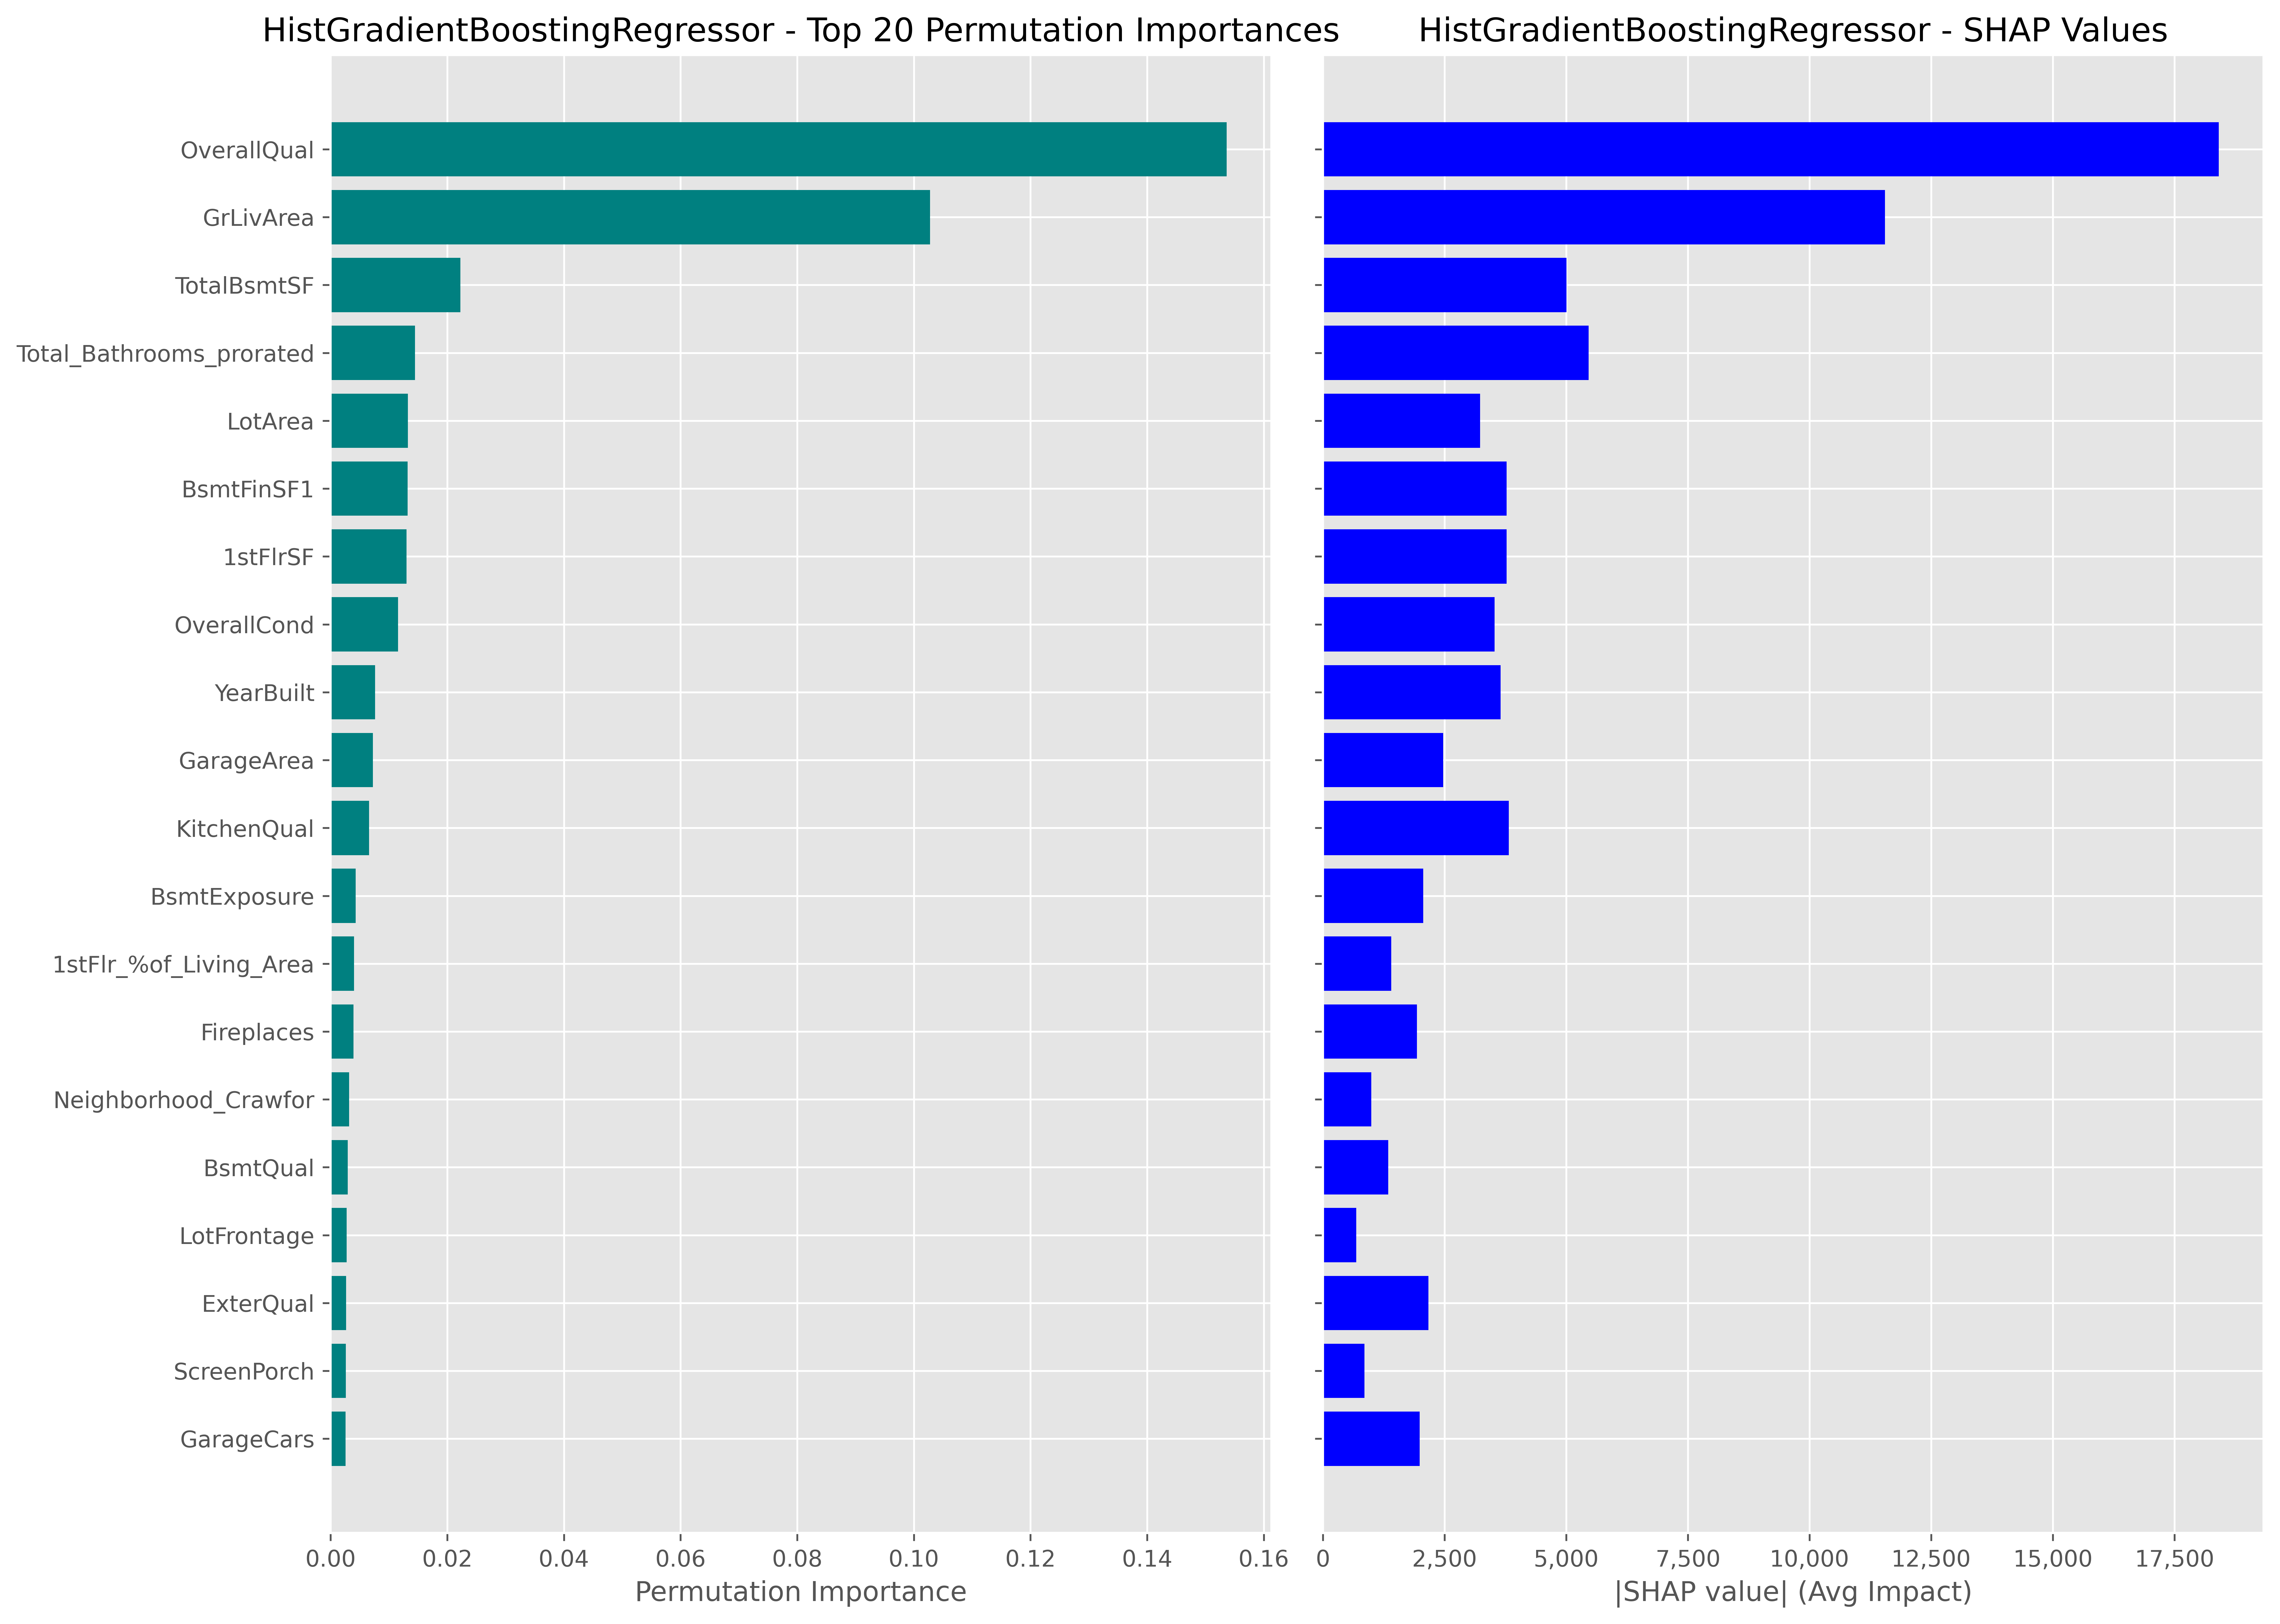

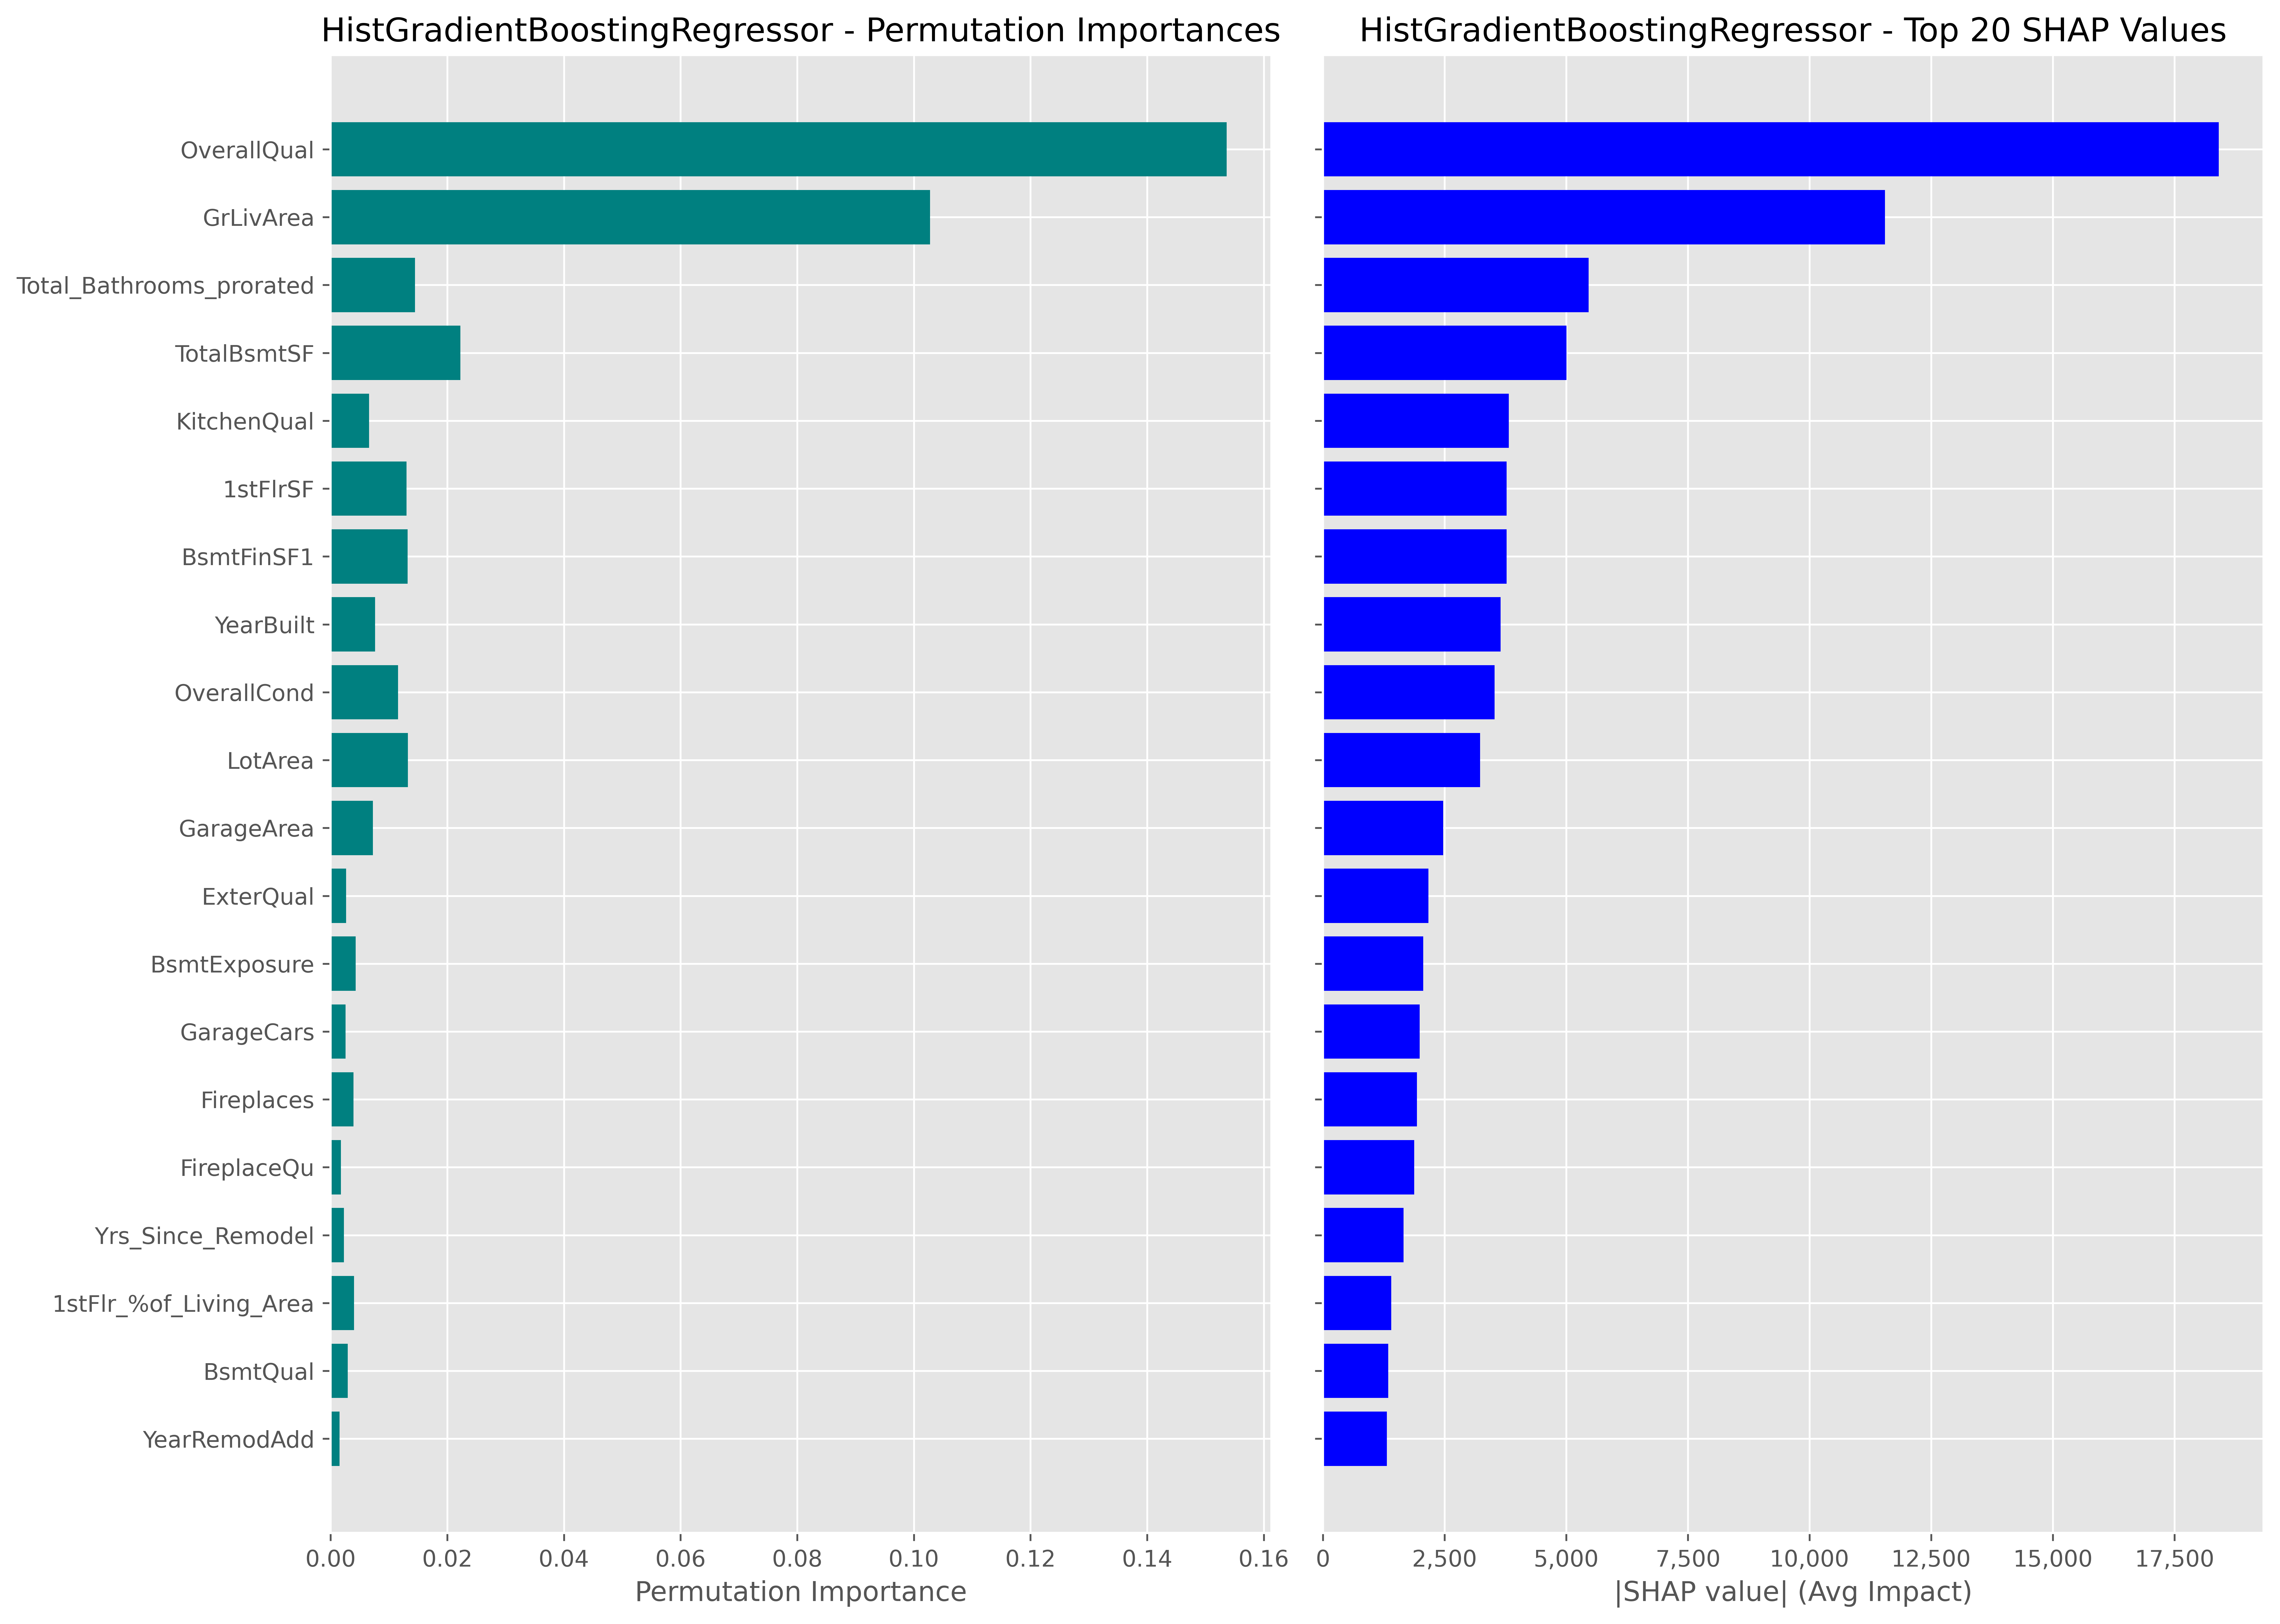


SHAP Beeswarm Plot for HistGradientBoostingRegressor...


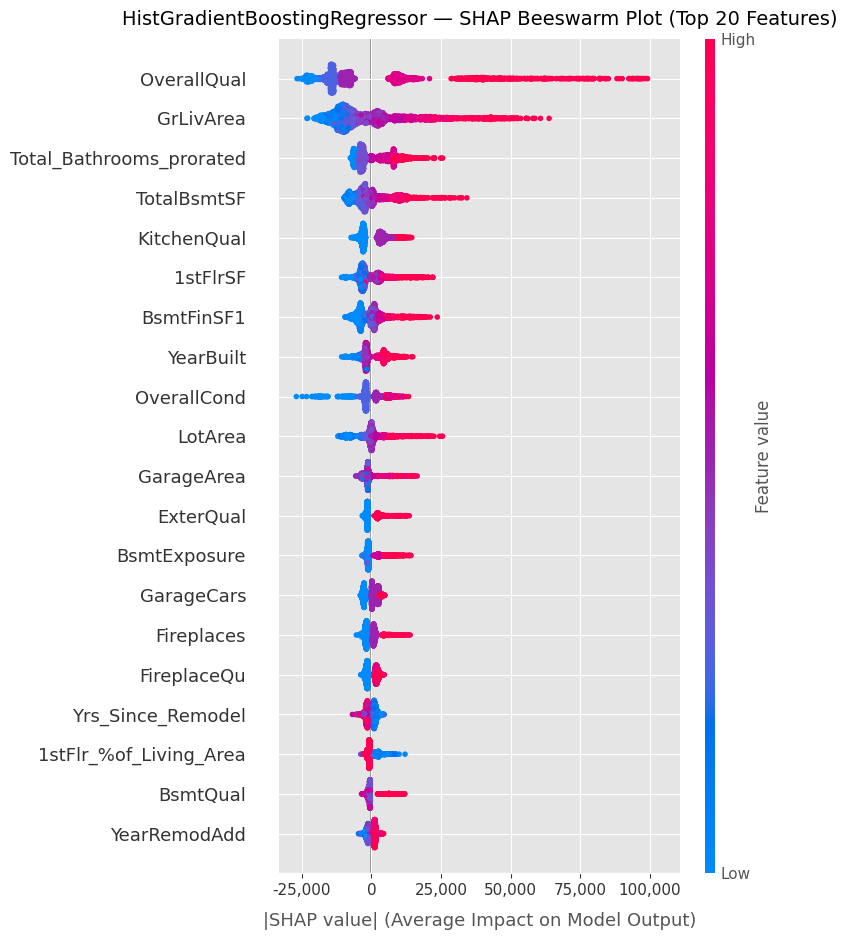

In [18]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_SHAP_Importances(random_search_hgb)

In [11]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm.fit(X, Y)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [30]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X, Y).mean()))

XGBoost Base Model Score: 0.8984900116920471


In [12]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'subsample': np.linspace(0.1, 1, 10),
    'colsample_bytree': np.linspace(0.1, 1, 10),
    'max_depth': range(2, 11),
    'n_estimators': [50, 125, 200, 275, 350],
    'min_child_weight': range(1, 11),
    'gamma': np.linspace(0, 1, 5),
    'reg_lambda': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 5),
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

#Results Dataframe
xgbm_cv_results_df = pd.DataFrame(random_search_xgbm.cv_results_)
xgbm_best_row = xgbm_cv_results_df.loc[xgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
xgbm_fold_scores = [xgbm_best_row[f'split{i}_test_score'] for i in range(5)]
xgbm_tuned_results_df = pd.DataFrame({
    'Engineering': ['Post'],
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['XGBoost'],
    'Mean_R²': [xgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [xgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': np.float64(0.7000000000000001), 'reg_lambda': np.float64(0.0), 'reg_alpha': np.float64(0.5), 'n_estimators': 350, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': np.float64(0.05000000000000001), 'gamma': np.float64(0.75), 'colsample_bytree': np.float64(0.2)}
Best CV Score: 0.9246


PermutationExplainer explainer: 2580it [03:13, 13.09it/s]                                                              


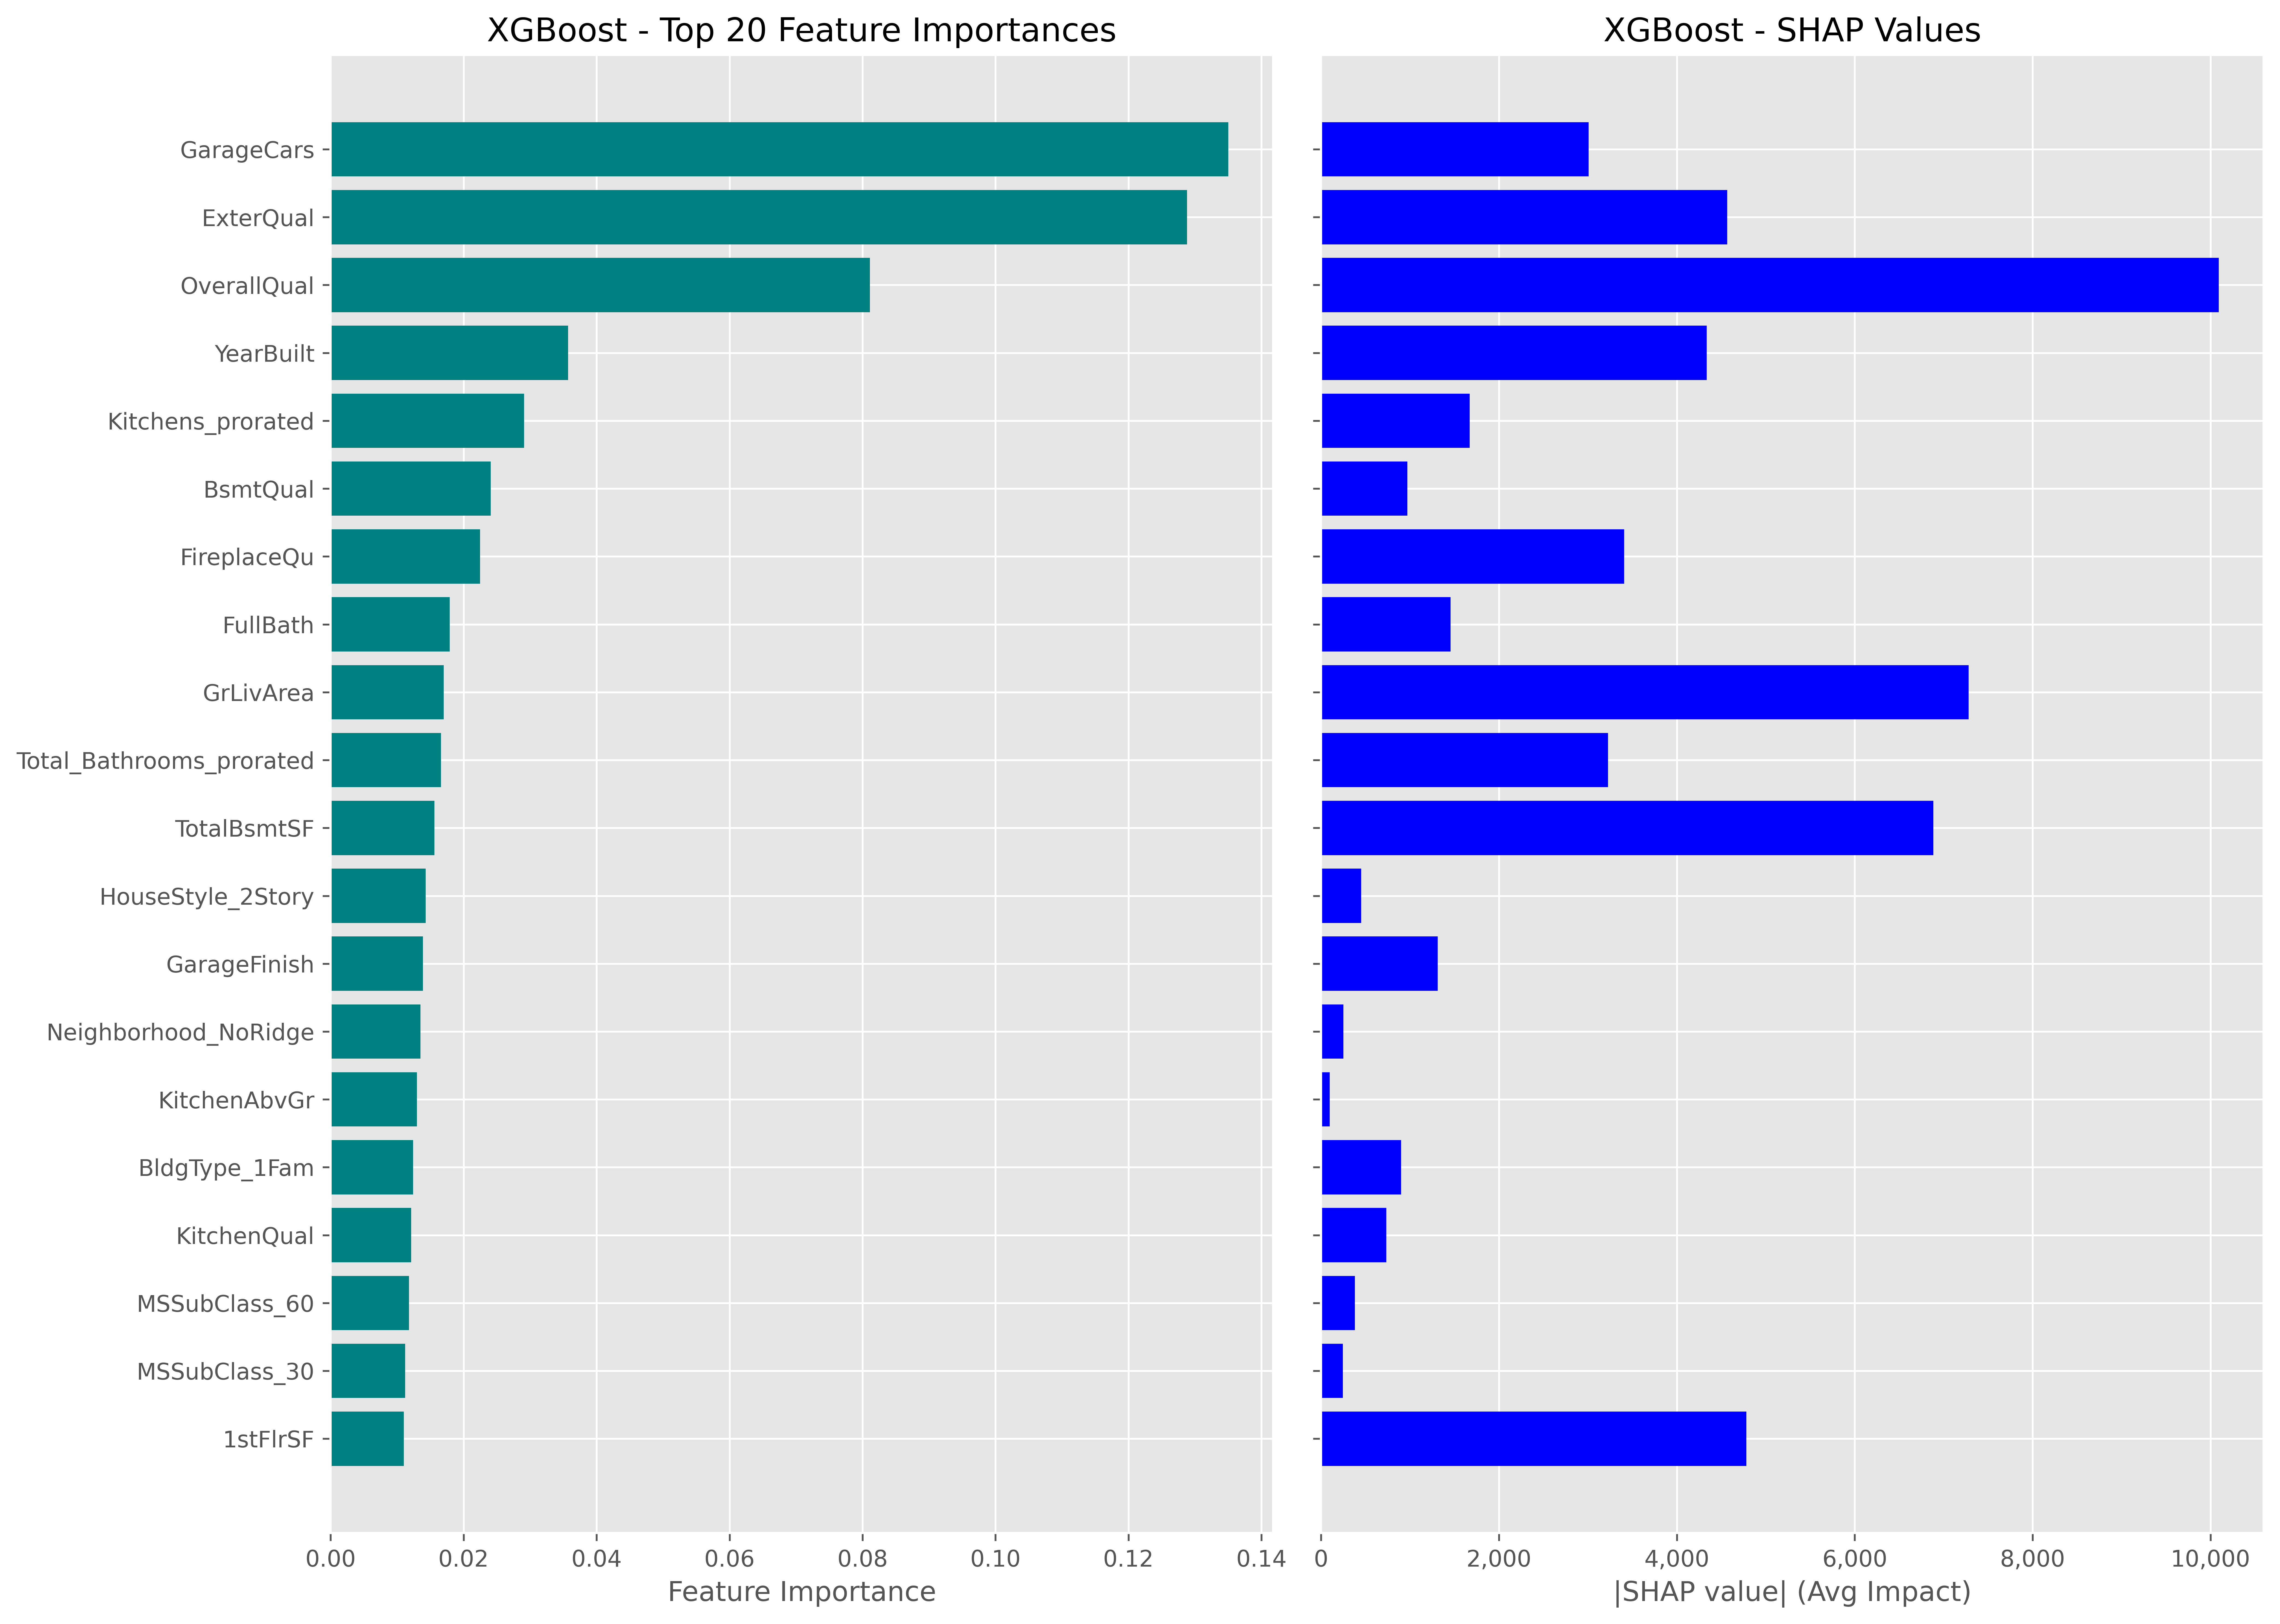

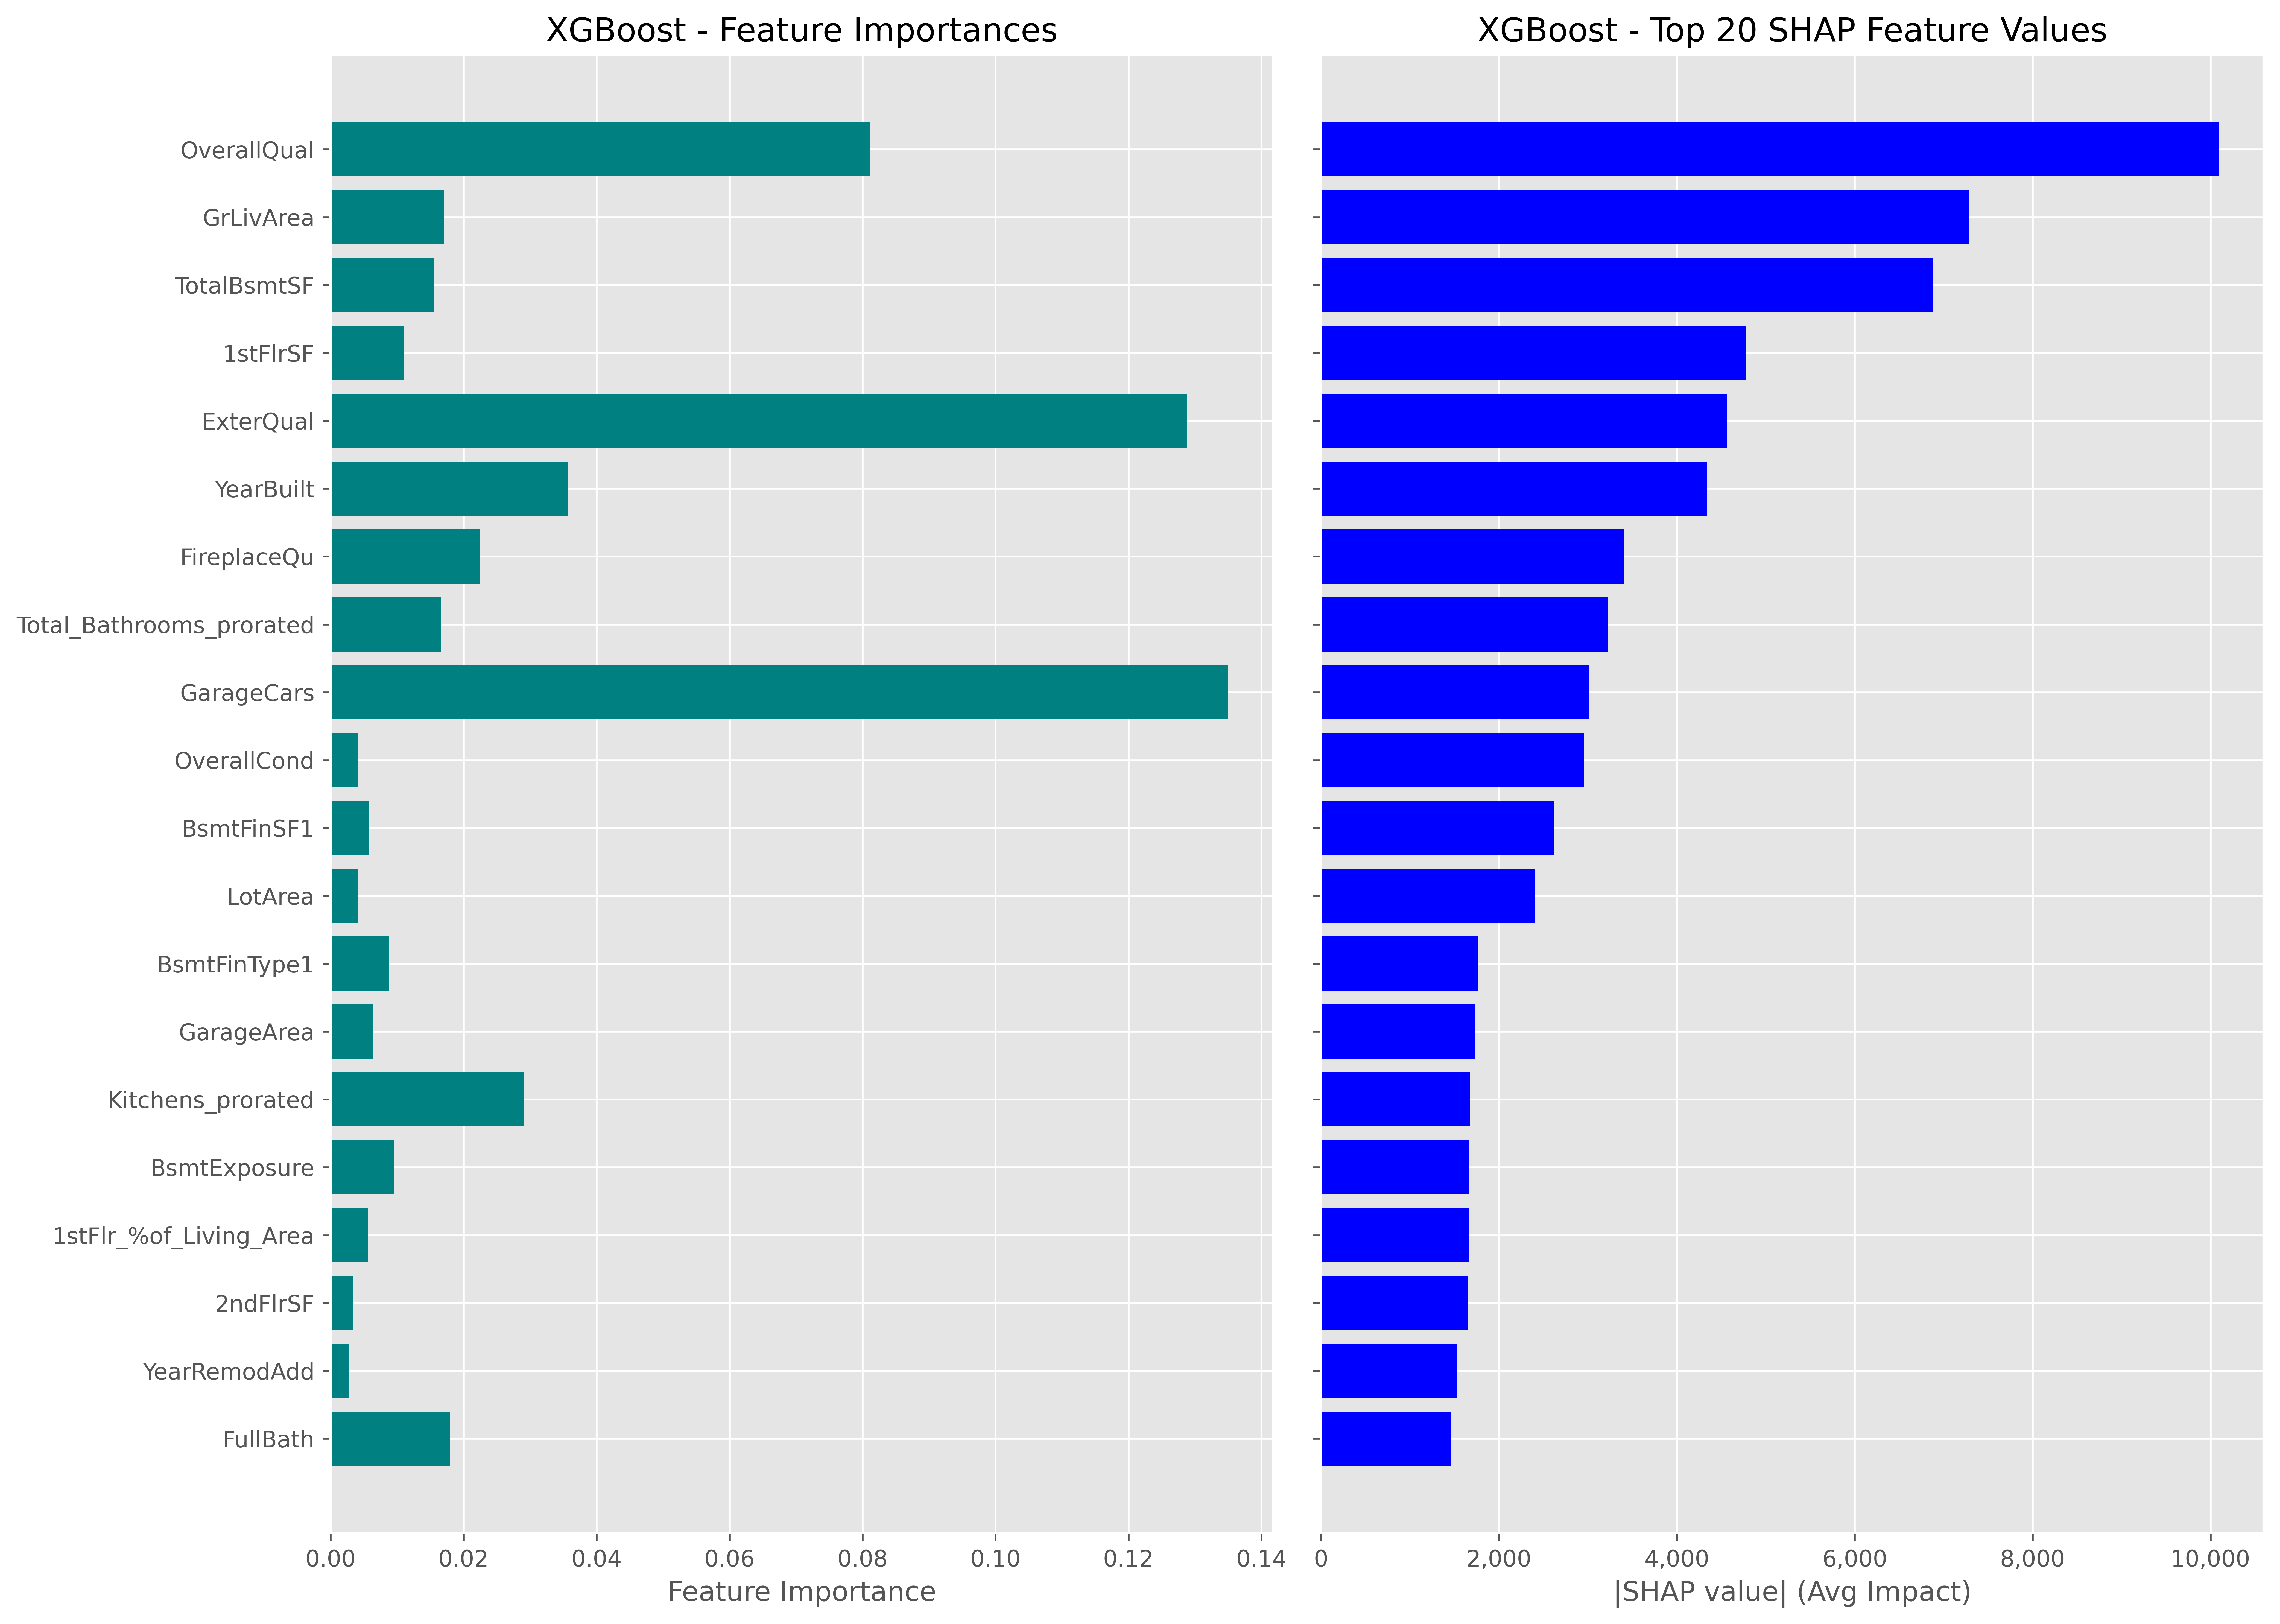


SHAP Beeswarm Plot for XGBoost...


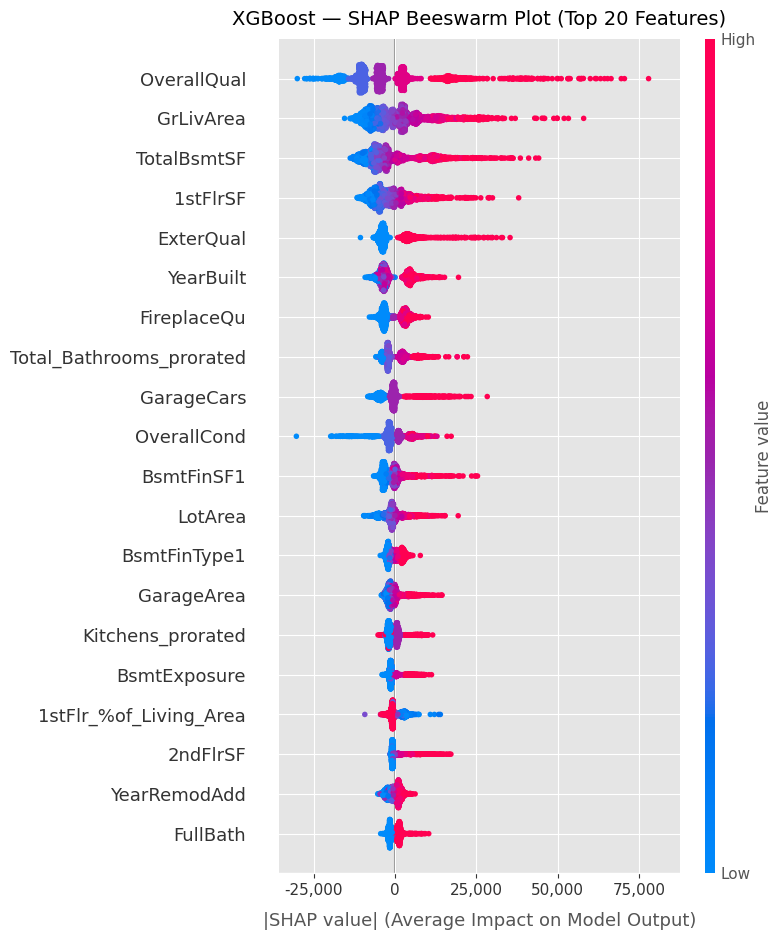

In [23]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_xgbm, 'XGBoost')

In [24]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X, Y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5162
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 181
[LightGBM] [Info] Start training from score 178053.442420


LGBMRegressor(n_jobs=-1, random_state=2, verbose=1)

In [34]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X, Y).mean()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5056
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 173
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5070
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 172
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [26]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [.25, .5, .75, 1],
    'colsample_bytree': [.25, .5, .75, 1],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_lambda': [0.0, 0.33, 0.67, 1],
    'reg_alpha': [0.0, 0.33, 0.67, 1]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5198
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 199
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.0, 'num_leaves': 15, 'n_estimators': 250, 'min_child_samples': 10, 'max_depth': 99, 'learning_rate': 0.1, 'colsample_bytree': 0.75}
Best CV Score: 0.9180


 99%|===================| 2556/2579 [00:18<00:00]        

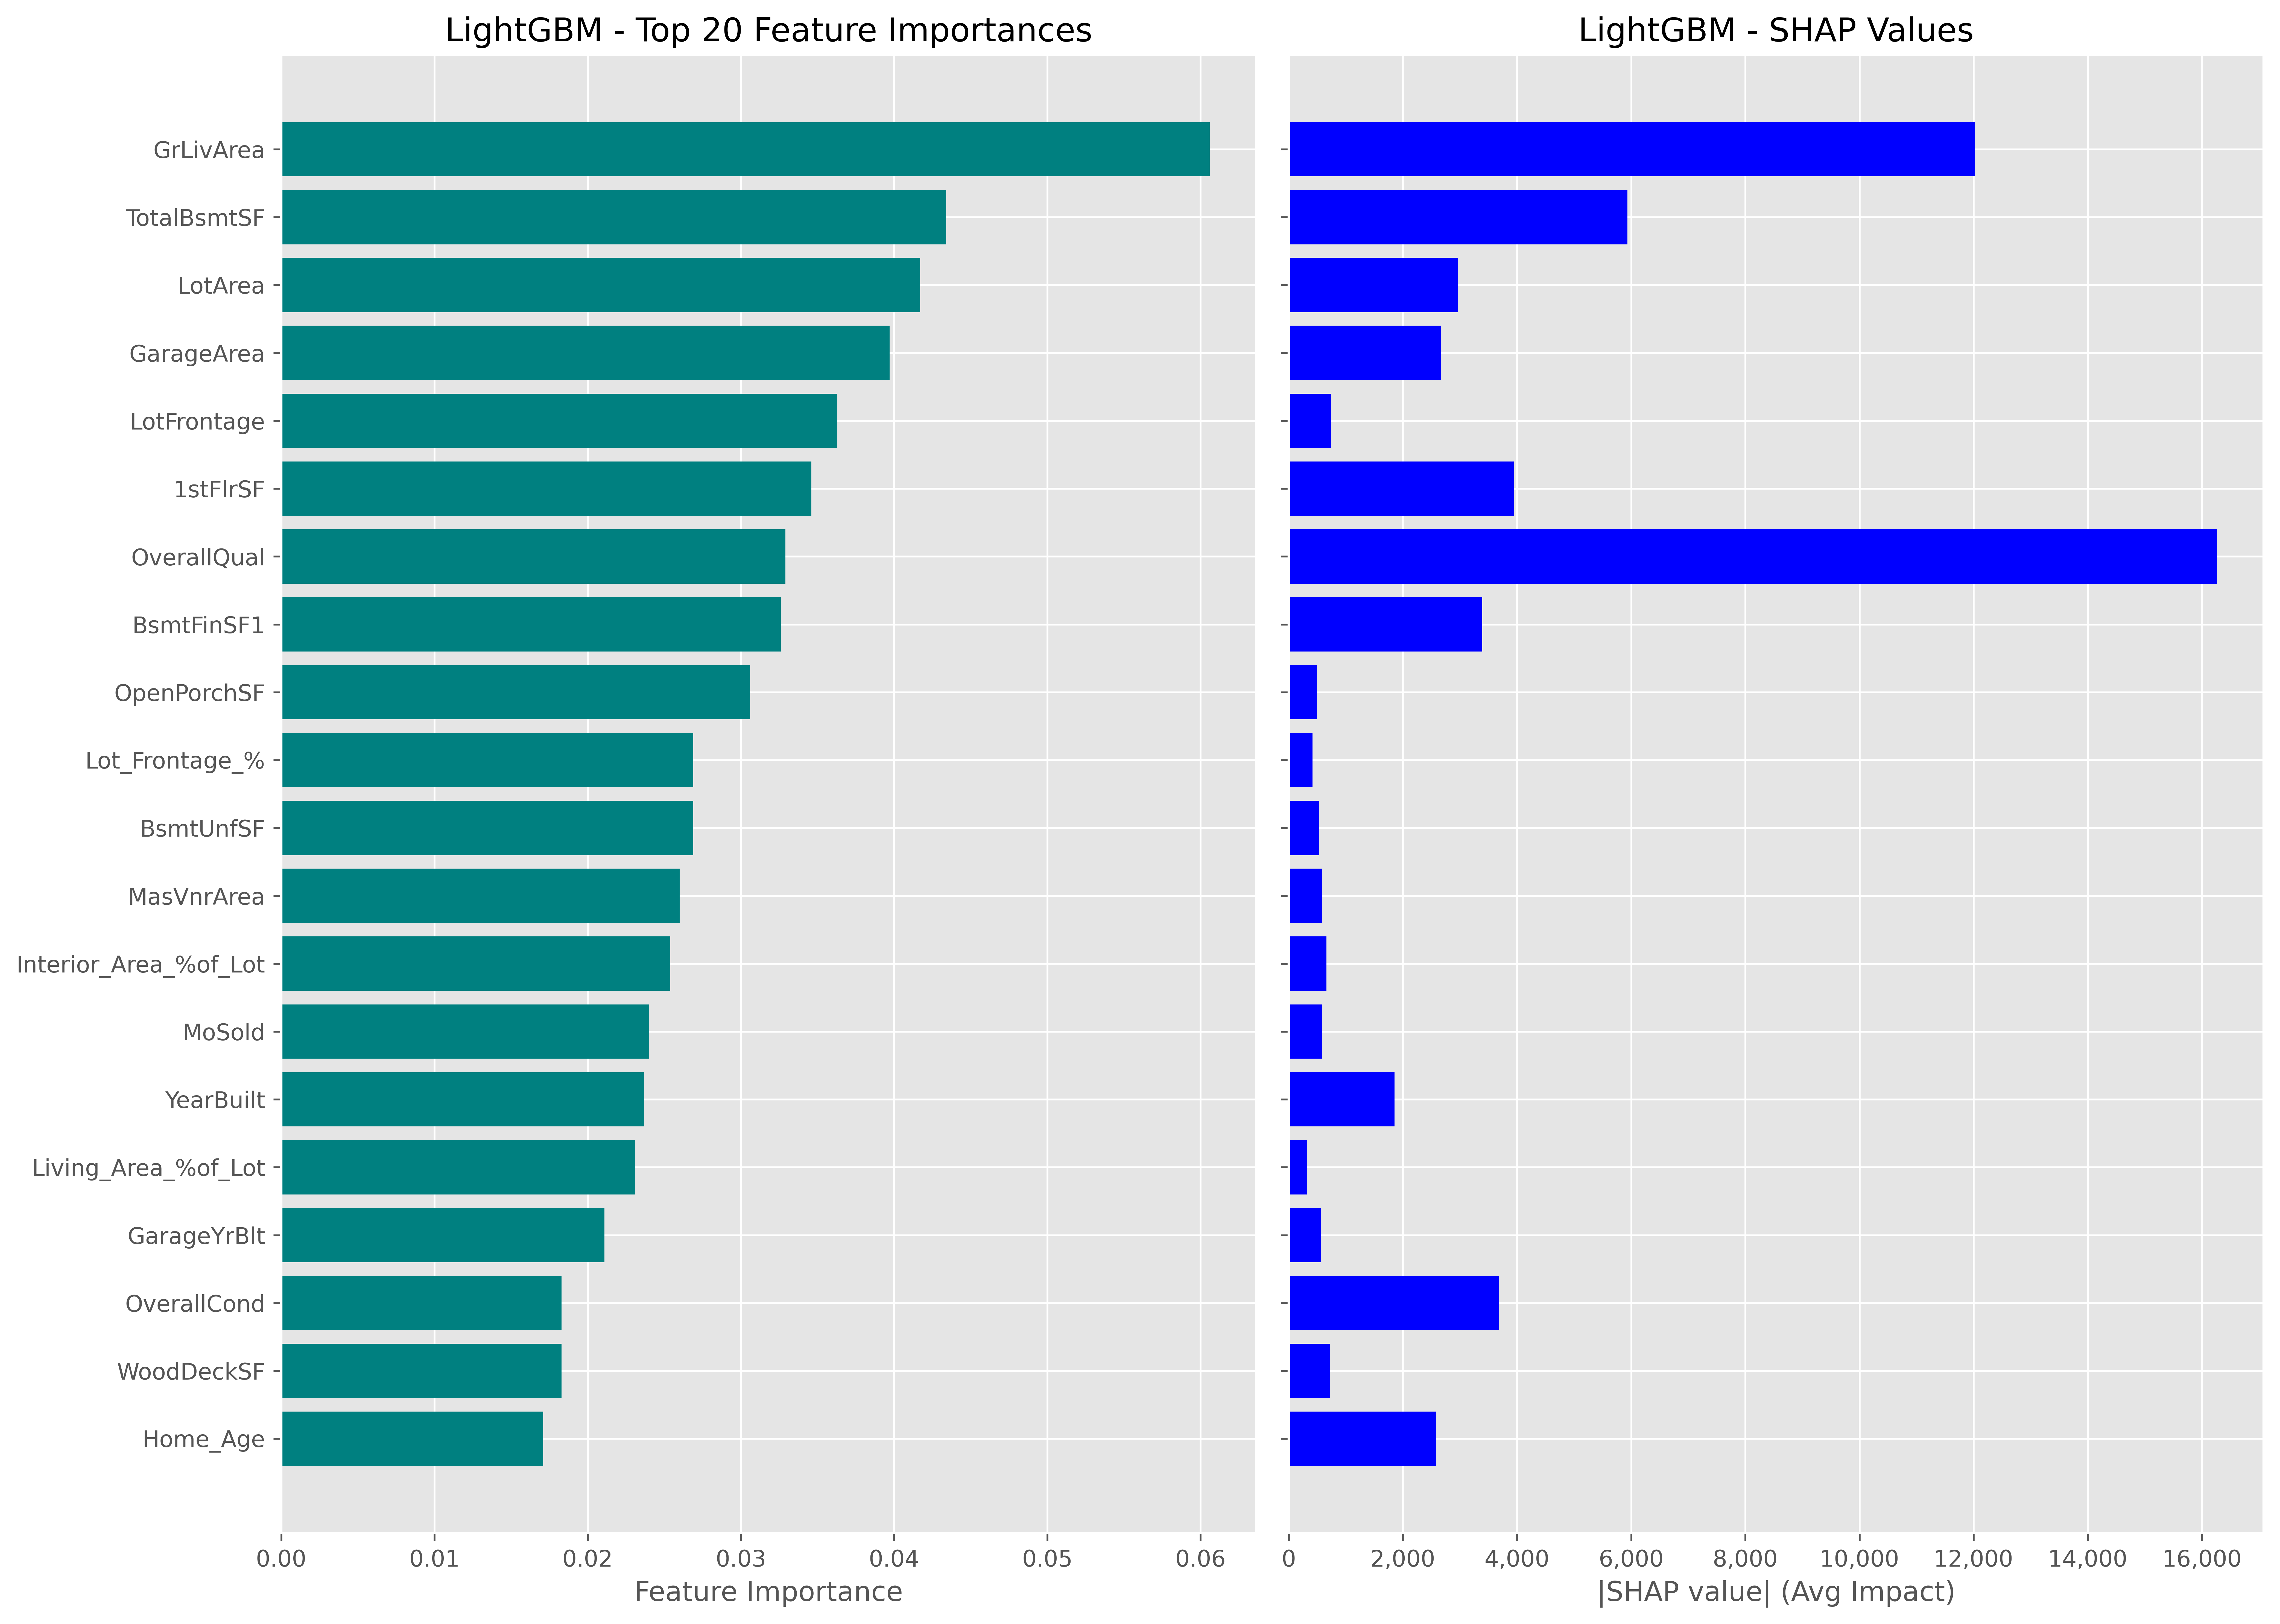

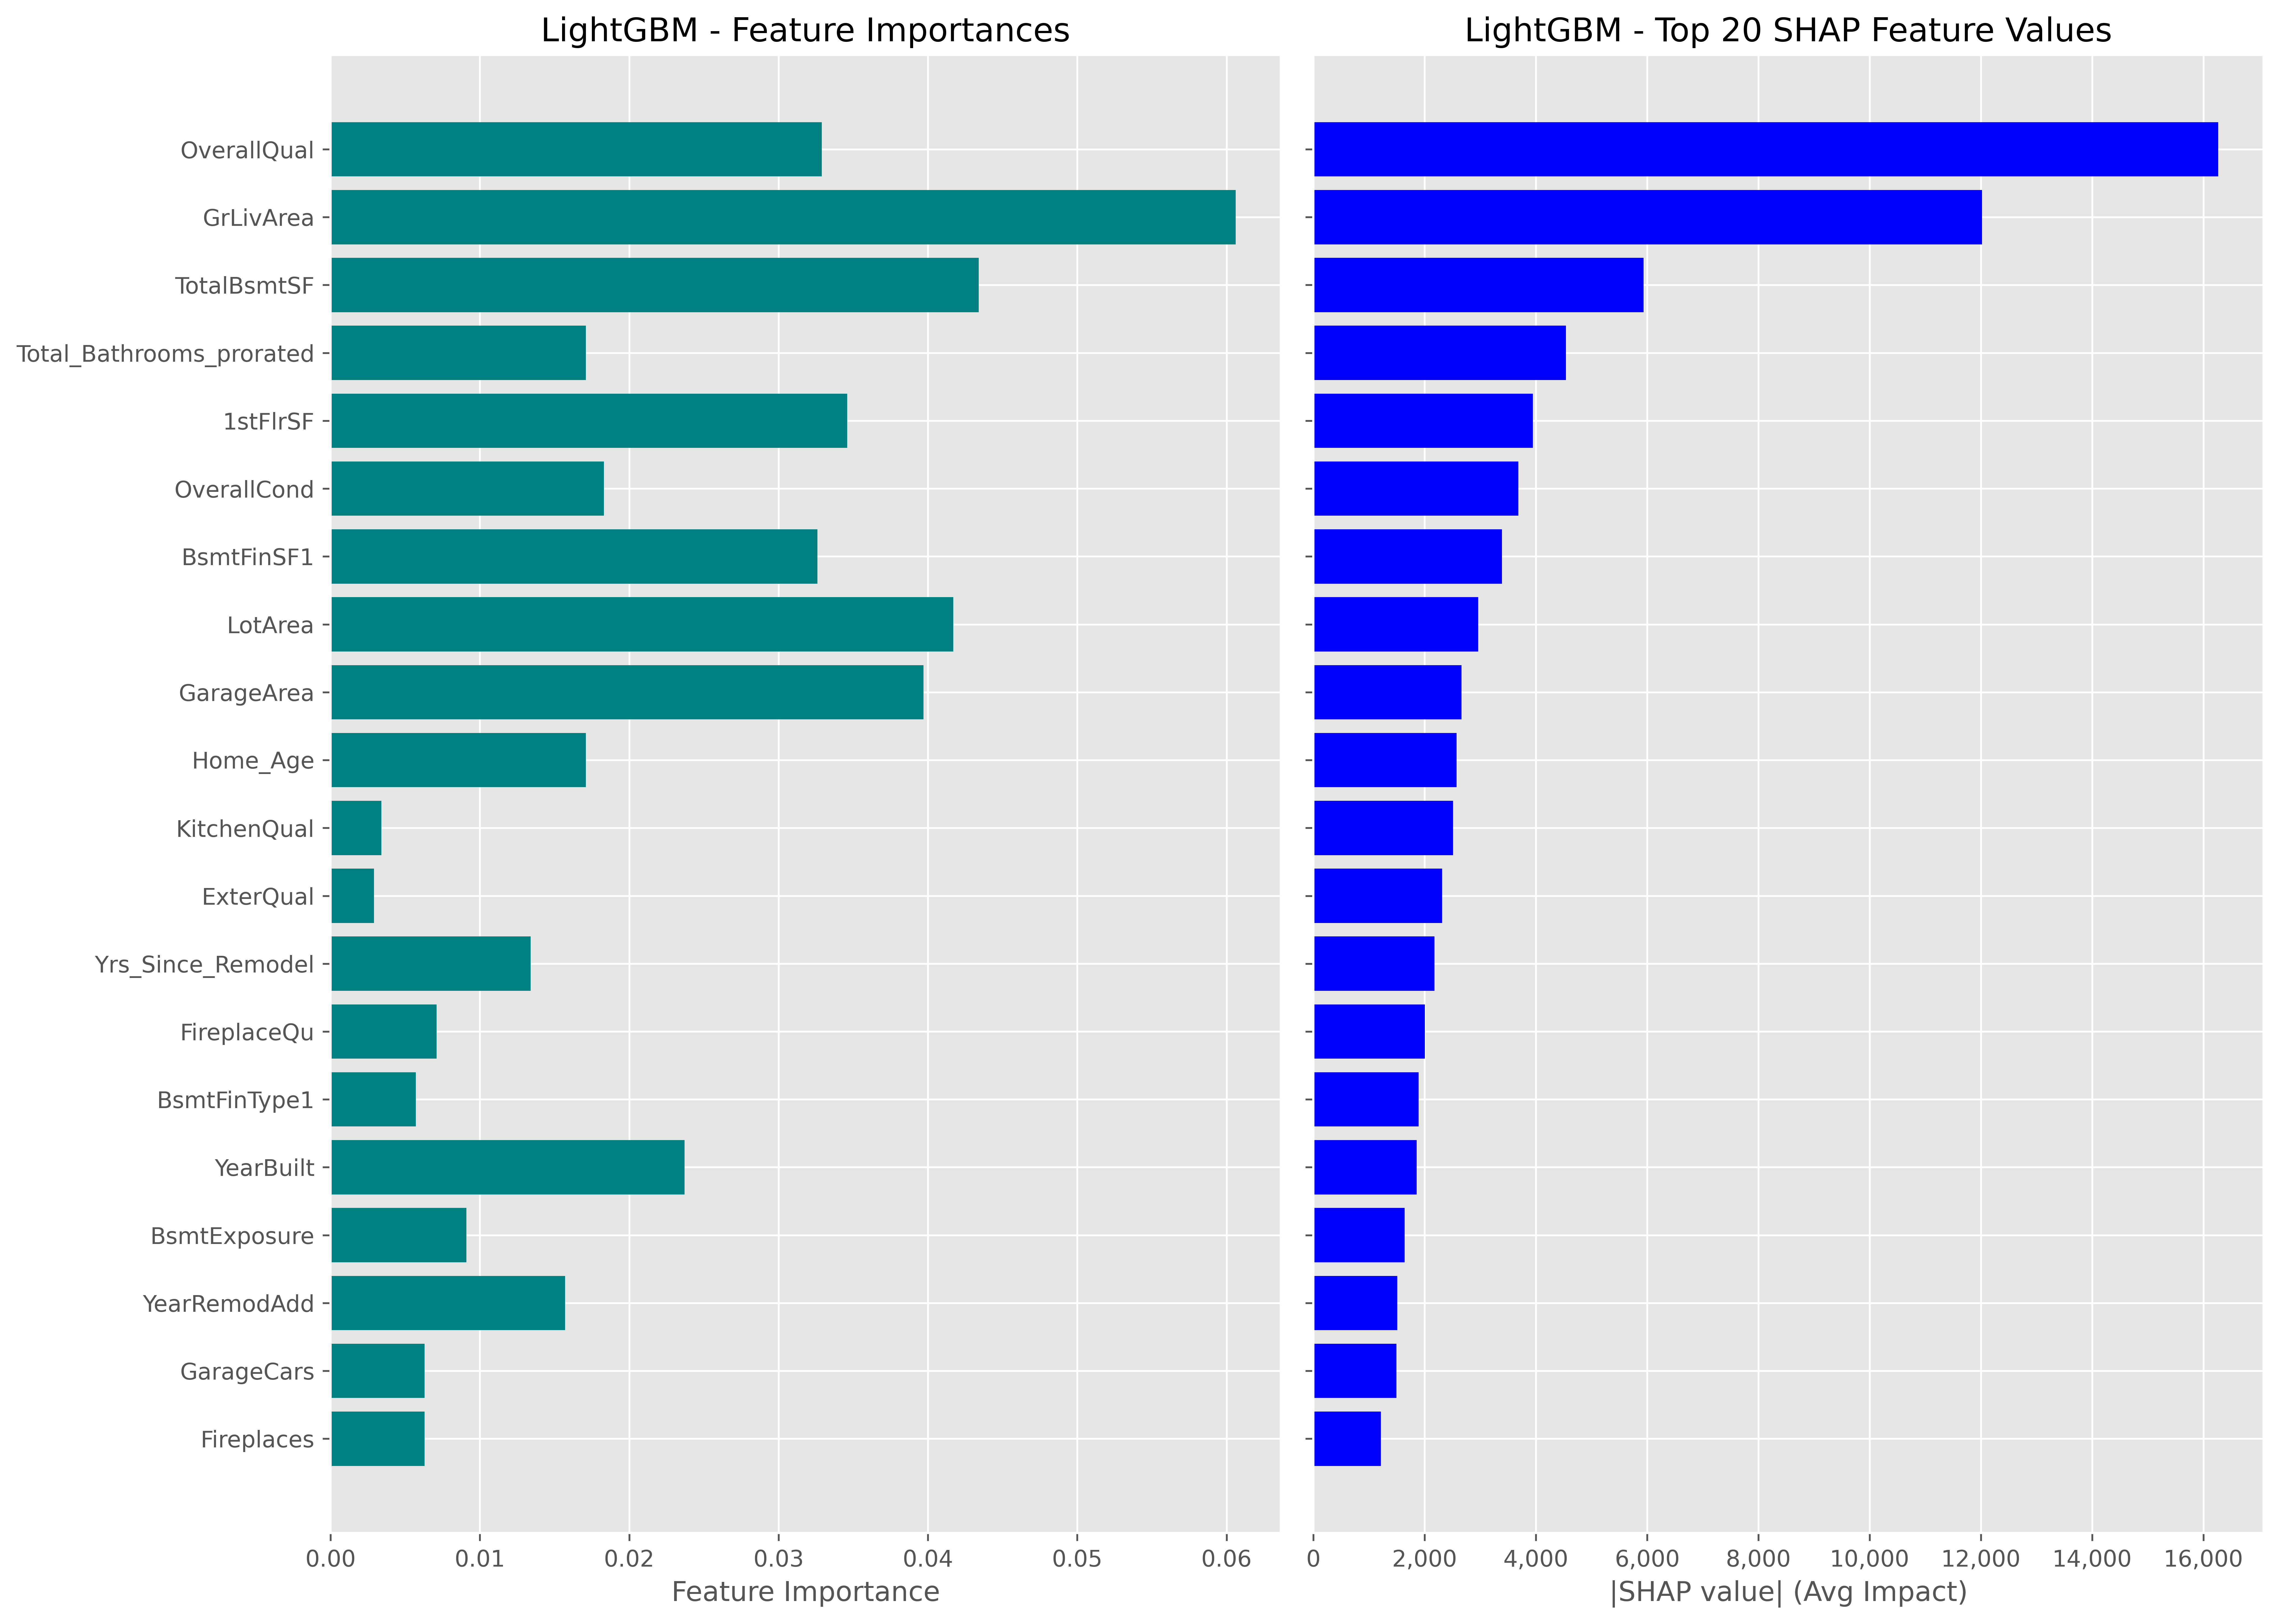


SHAP Beeswarm Plot for LightGBM...


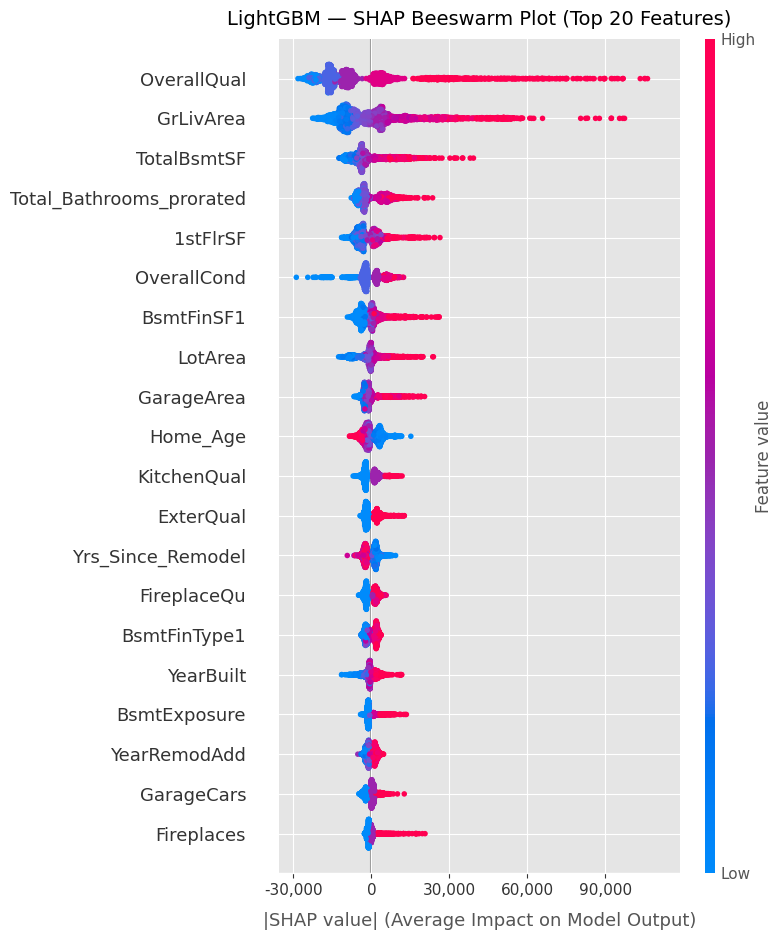

In [27]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm, 'LightGBM')

In [28]:
lgbm_GOSS = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1, boosting_type='goss')
lgbm_GOSS.fit(X, Y)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5162
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 181
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=2, verbose=1)

In [9]:
print('LightGBM GOSS Base Model Score:', float(cross_val_score(lgbm_GOSS, X, Y).mean()))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5056
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 173
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [29]:
#Initial LightGBM GOSS RandomizedSearchCV for faster estimates
lgbm_GOSS_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [.25, .5, .75, 1],
    'colsample_bytree': [.25, .5, .75, 1],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_lambda': [0.0, 0.33, 0.67, 1],
    'reg_alpha': [0.0, 0.33, 0.67, 1]
}
random_search_lgbm_GOSS = RandomizedSearchCV(
    estimator=lgbm_GOSS,
    param_distributions=lgbm_GOSS_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm_GOSS.fit(X, Y)
print('Best parameters:', random_search_lgbm_GOSS.best_params_)
print(f'Best CV Score: {random_search_lgbm_GOSS.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5162
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 181
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Warning] No further splits with positive gai

 98%|===================| 2531/2579 [00:38<00:00]        

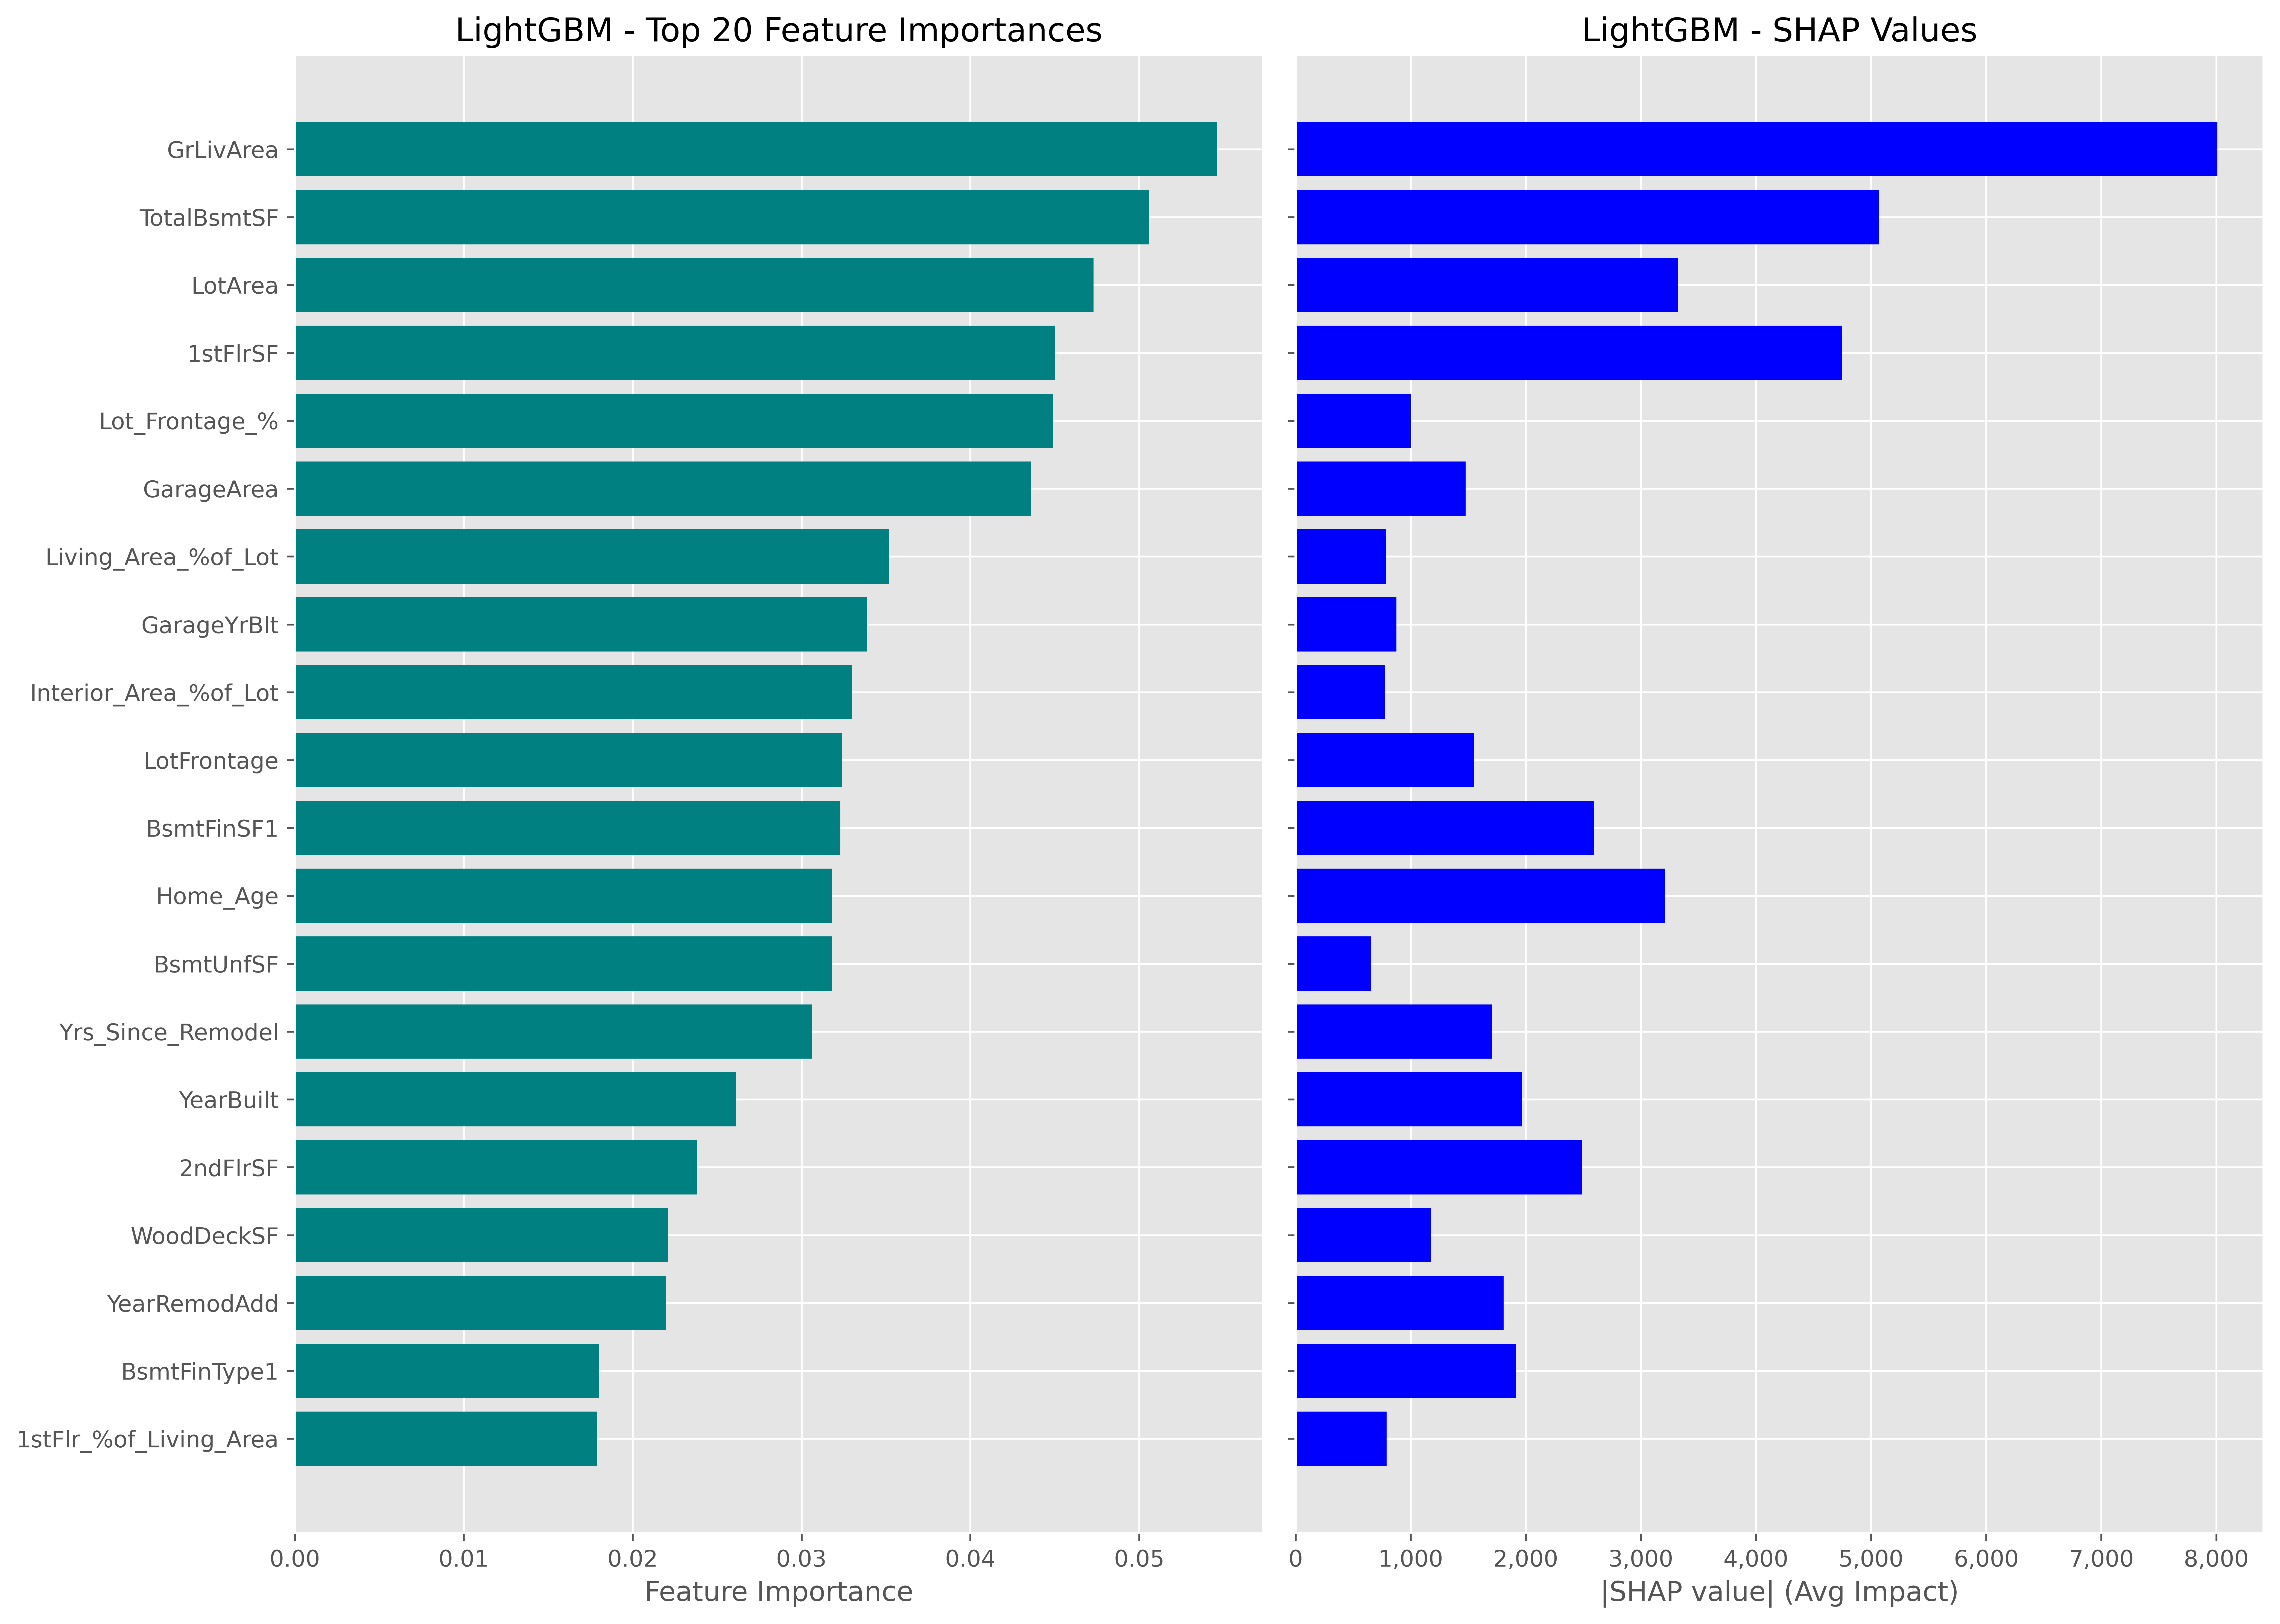

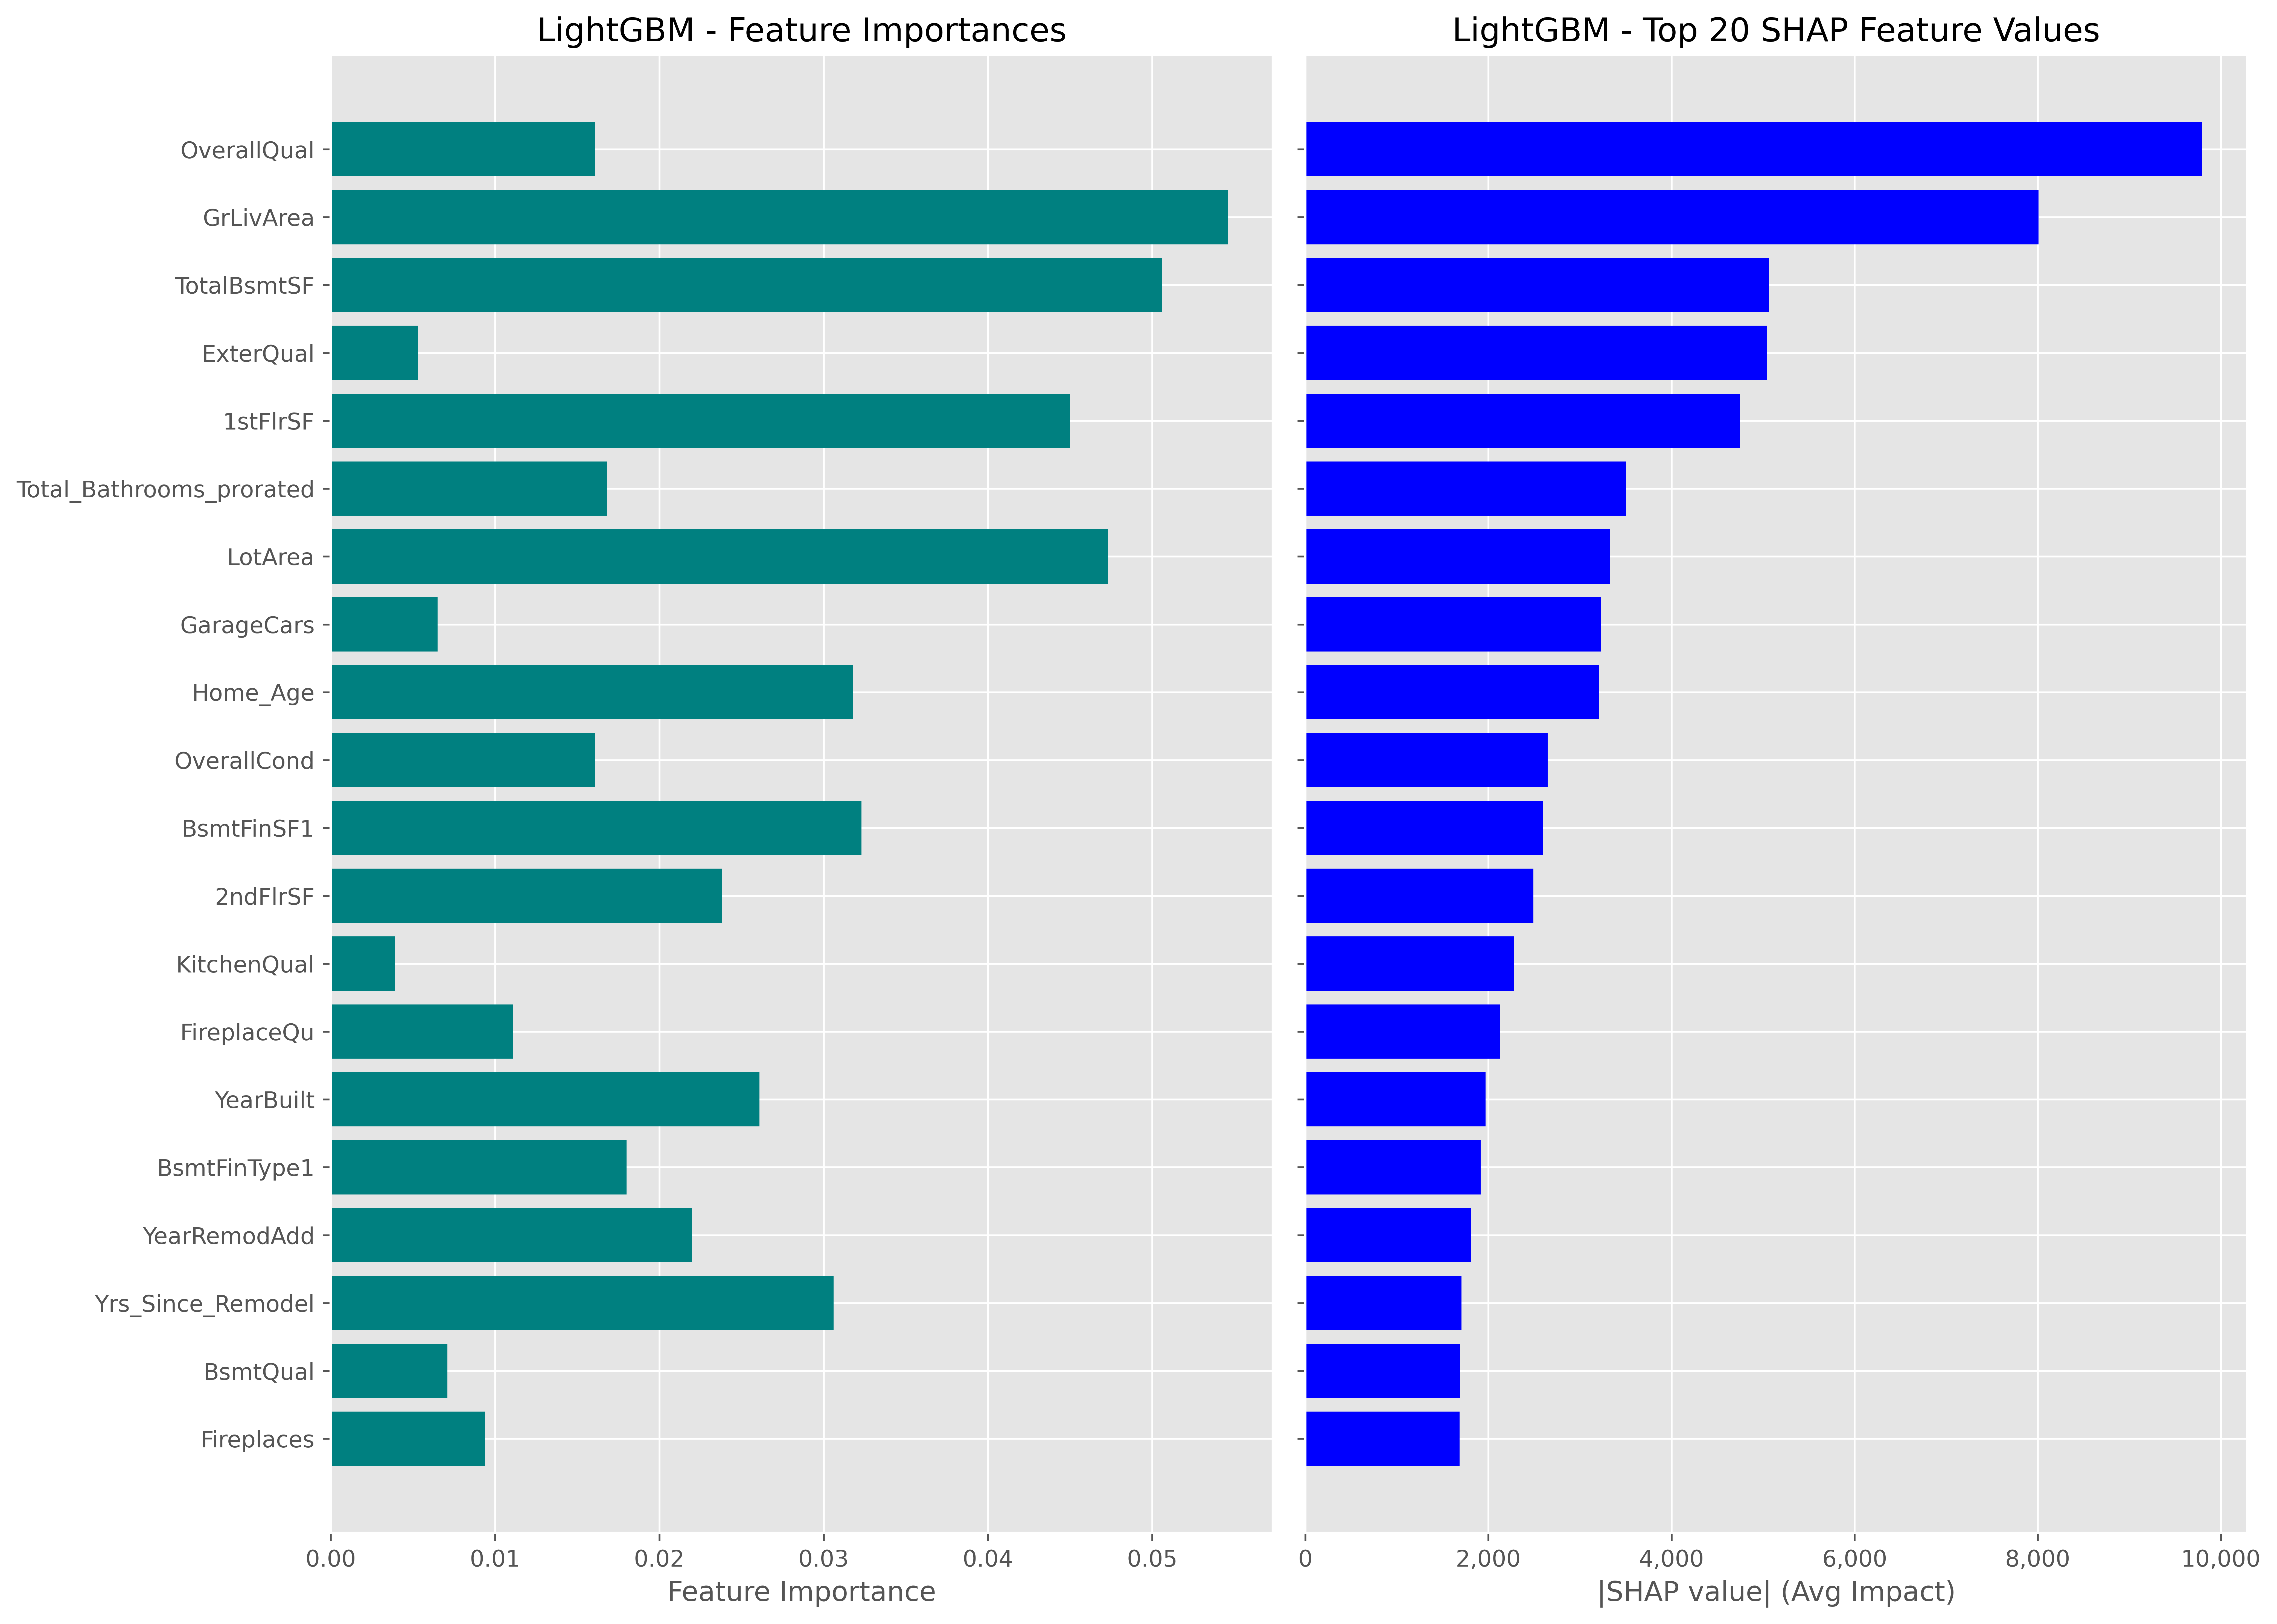


SHAP Beeswarm Plot for LightGBM...


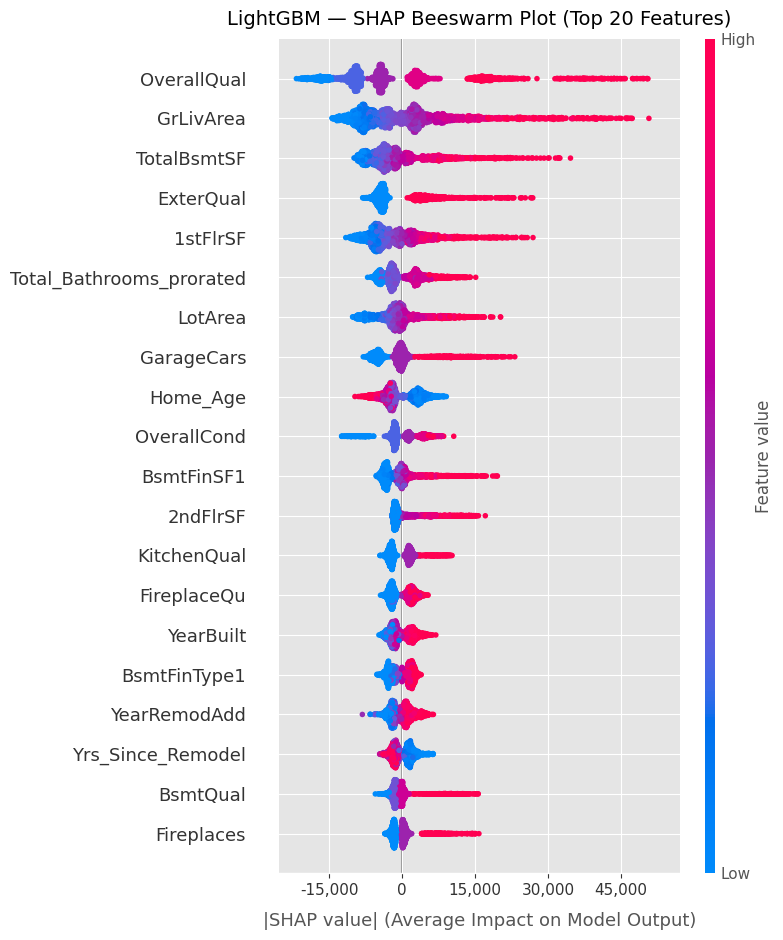

In [30]:
#LightGBM GOSS Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm_GOSS, 'LightGBM')

In [13]:
#Base CatBoost Model
cat_boost = CatBoostRegressor(random_state=2, verbose=0, thread_count=-1)
cat_boost_cv_scores = cross_val_score(cat_boost, X, Y, cv=5, scoring='r2')
cat_boost.fit(X, Y)
cat_boost_mean_cv_score = np.mean(cat_boost_cv_scores)
print(f'CatBoost Base Model Mean CV R²: {cat_boost_mean_cv_score}')

#Results Dataframe
cat_base_results_df = pd.DataFrame({
    'Engineering': ['Post'],
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['CatBoost'],
    'Mean_R²': [cat_boost_mean_cv_score],
    **{f'Fold_{i+1}_R²': [cat_boost_cv_scores[i]] for i in range(5)}
})

CatBoost Base Model Mean CV R²: 0.9324963725823372


In [38]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X, Y).mean()))

CatBoost Base Model Score: 0.9324963725823372


In [39]:
#Initial CatBoost RandomizedSearchCV for faster estimates
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'min_data_in_leaf': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'iterations': 172, 'depth': 8, 'colsample_bylevel': 0.7}
Best CV Score: 0.9258


 99%|===================| 2552/2579 [00:46<00:00]        

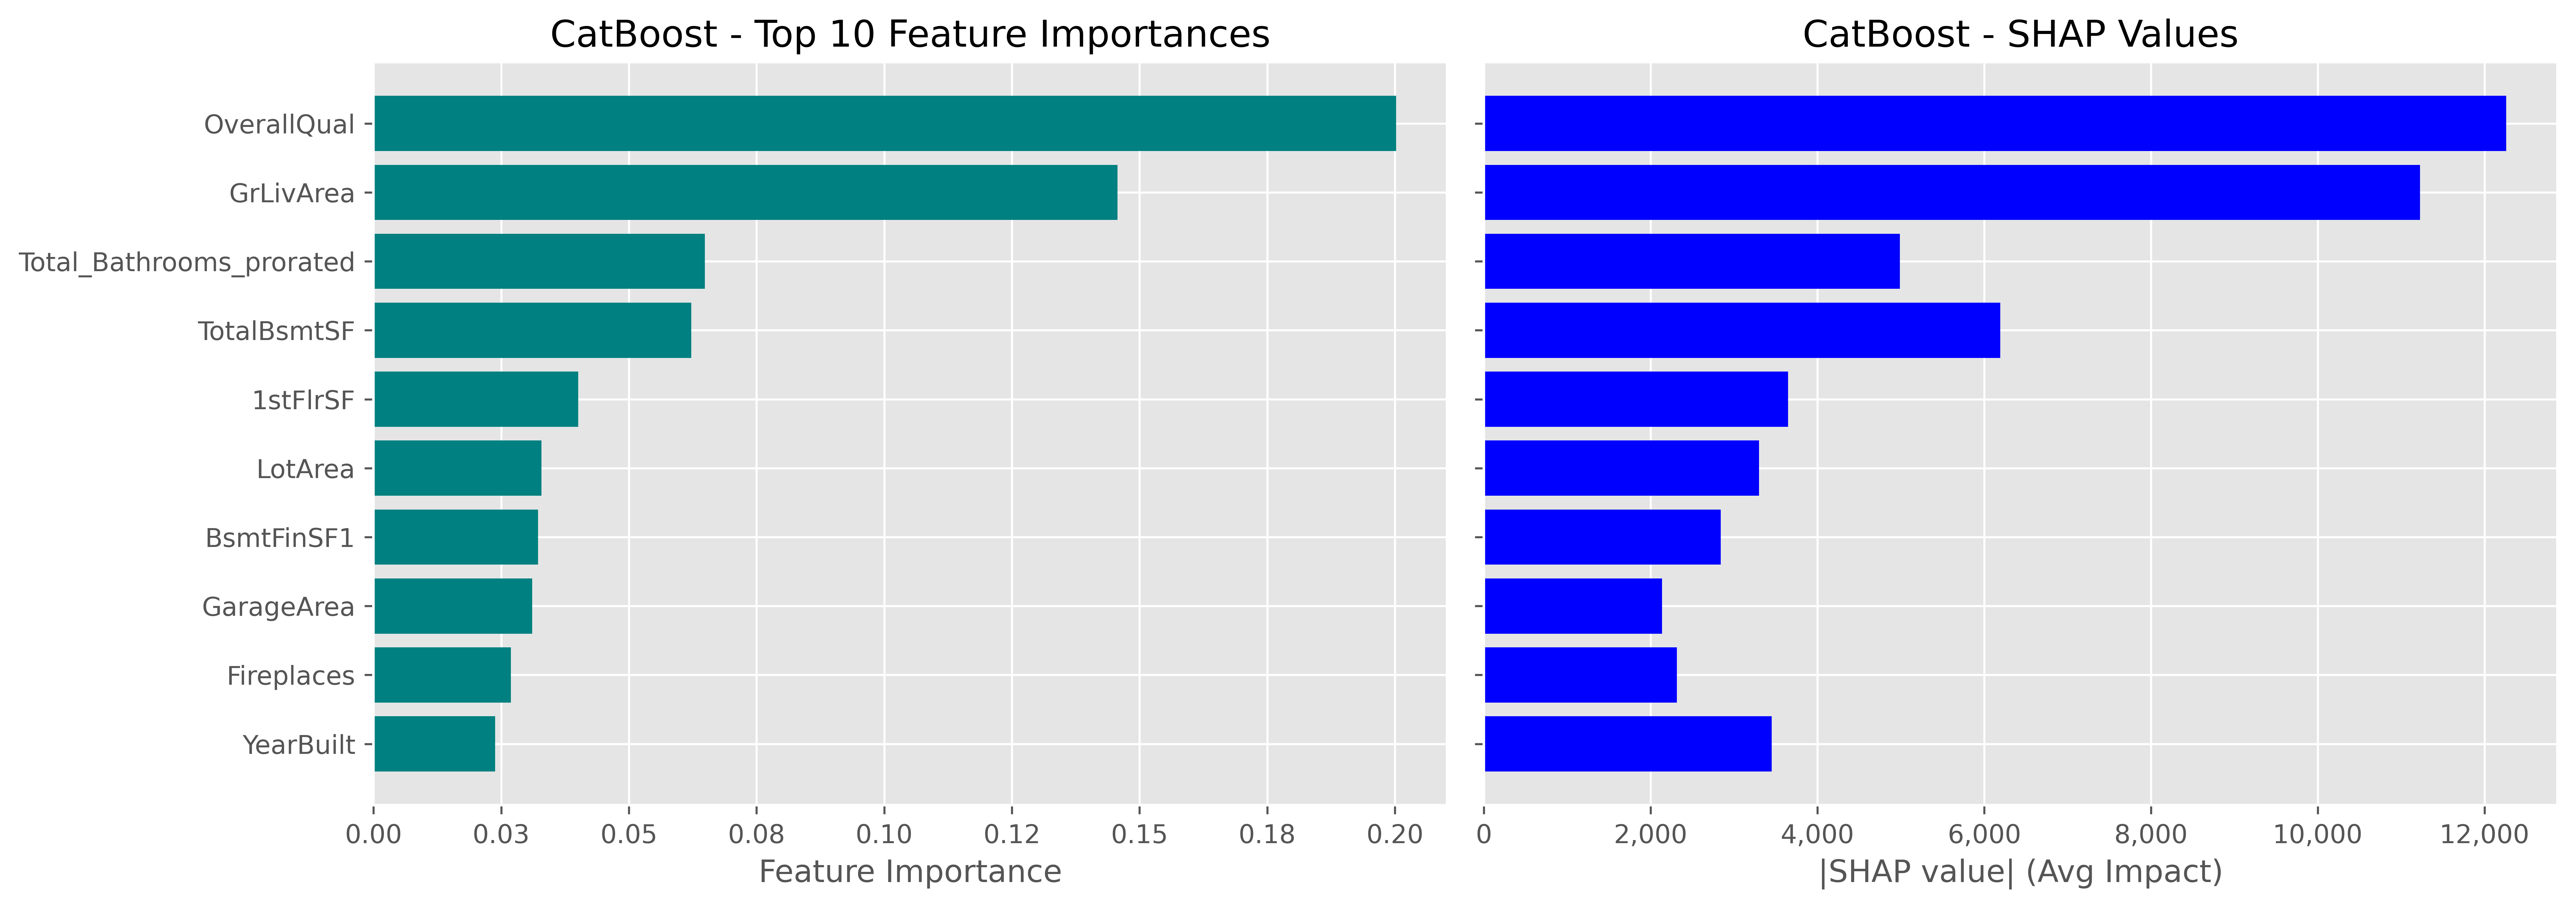

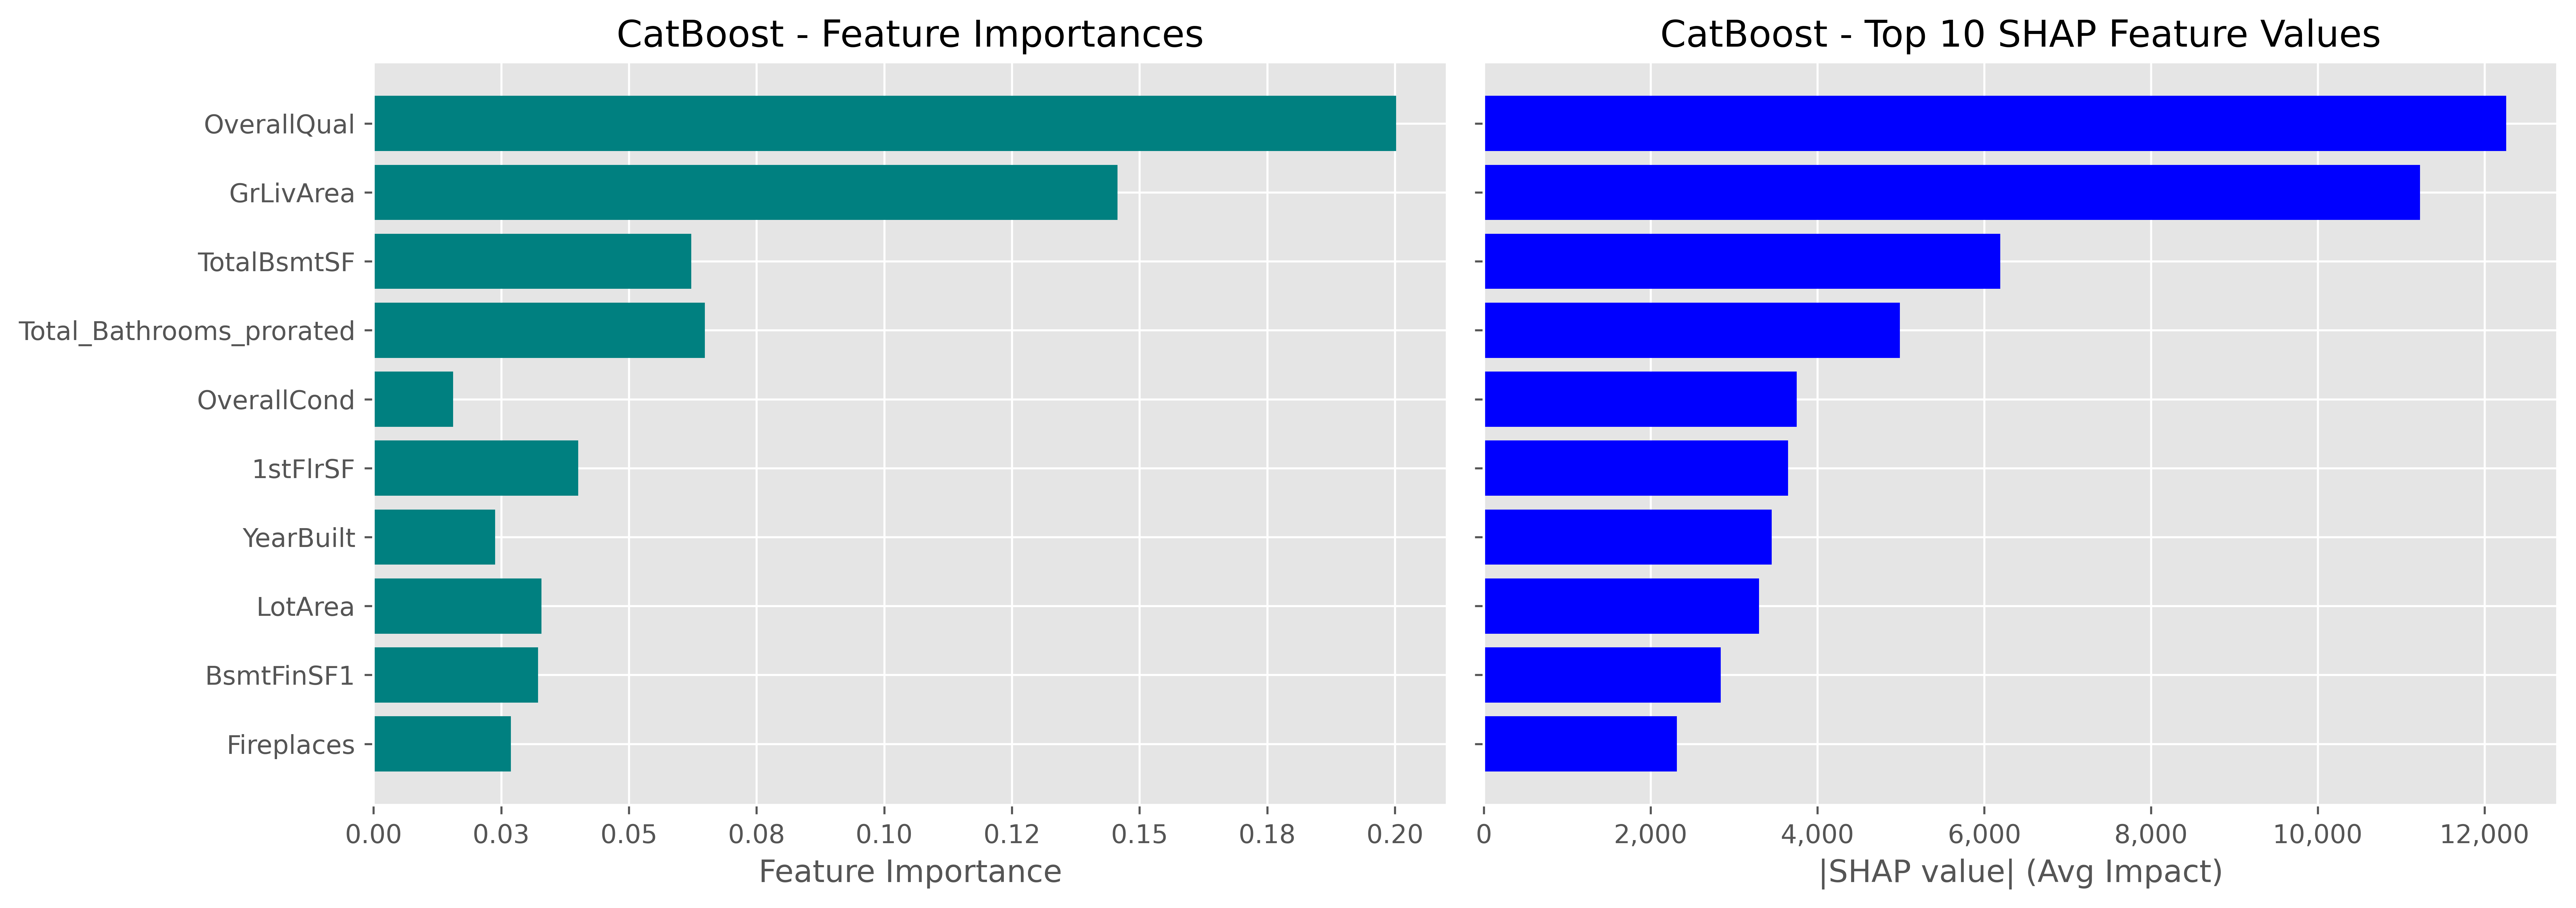


SHAP Beeswarm Plot for CatBoost...


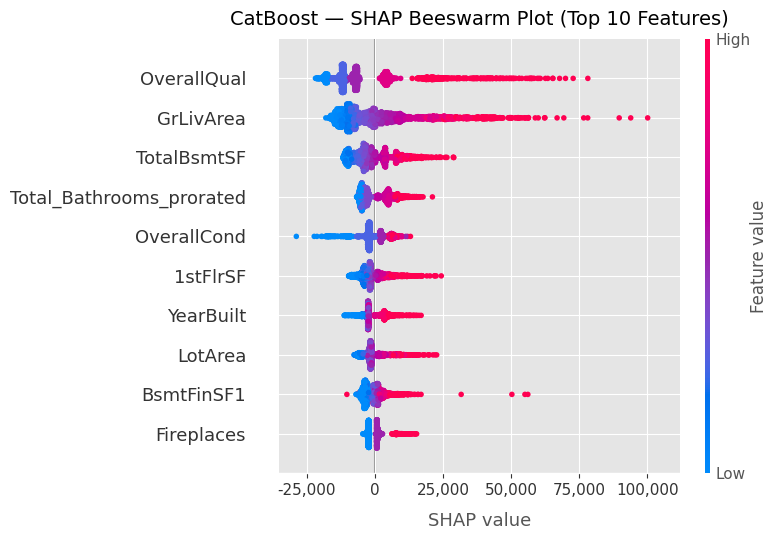

In [8]:
#CatBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(cat_boost, 'CatBoost')

In [41]:
#Base AdaBoost Model
adaBoost = AdaBoostRegressor(estimator = tree_model, random_state=2)
adaBoost.fit(X, Y)

AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=2),
                  random_state=2)

In [42]:
print('AdaBoost Base Model Score:', float(cross_val_score(adaBoost, X, Y).mean()))

AdaBoost Base Model Score: 0.8935088463413914


In [61]:
#Initial AdaBoost RandomizedSearchCV for faster estimates
'''
adaBoost_param = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7, 9, 11],
    'n_estimators': range(100, 250),
    'loss': ['linear', 'square', 'exponential']
}
random_search_adaBoost = RandomizedSearchCV(
    estimator=adaBoost,
    param_distributions=adaBoost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_adaBoost.fit(X, Y)
print('Best parameters:', random_search_adaBoost.best_params_)
print(f'Best CV Score: {random_search_adaBoost.best_score_:.4f}')
'''

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 184, 'loss': 'linear', 'learning_rate': 0.2, 'estimator__max_depth': 7}
Best CV Score: 0.8893


In [ ]:
#AdaBoost Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(adaBoost, 'AdaBoost')
'''

In [15]:
#Concatenate all Results
Tree_Results_df_Engineered = pd.concat(
    [gbm_tuned_results_df,
    xgbm_tuned_results_df,
    cat_base_results_df],
    axis=0,
    ignore_index=True
)

#Better Score column (Base vs Tuned)
Tree_Results_df_Engineered['Model_Clean'] = Tree_Results_df_Engineered['Model'].str.replace('_Base|_Tuned', '', regex=True)
Tree_Results_df_Engineered['Better_Score'] = False
for model_name, group in Tree_Results_df_Engineered.groupby('Model_Clean'):
    best_idx = group['Mean_R²'].idxmax()
    Tree_Results_df_Engineered.loc[best_idx, 'Better_Score'] = True
Tree_Results_df_Engineered.drop(columns=['Model_Clean'], inplace=True)

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
Tree_Results_df_Engineered

Engineering Model_Category Model_Scaling Tuning             Model  Mean_R²  \
0        Post     Tree_Based          None  Tuned  GradientBoosting   0.9165   
1        Post     Tree_Based          None  Tuned           XGBoost   0.9246   
2        Post     Tree_Based          None   Base          CatBoost   0.9325   

   Fold_1_R²  Fold_2_R²  Fold_3_R²  Fold_4_R²  Fold_5_R²  Better_Score  
0     0.8768     0.9145     0.9297     0.9315     0.9302          True  
1     0.8661     0.9283     0.9382     0.9465     0.9440          True  
2     0.8926     0.9303     0.9485     0.9446     0.9465          True

In [16]:
#Export Results
Tree_Results_df_Engineered.to_csv('Tree_Results_PostEngineering.csv', index=False)